# Image Generation using GANs

GANs were invented in 2014 by Ian Goodfellow. There are a framework for teaching the deep learning model to capture the training data's distribution. They are made of two distinct models, a generator and a discriminator. The job of the generator is to spawn ‘fake’ images that look like the training images. The job of the discriminator is to look at an image and output whether or not it is a real training image or a fake image from the generator. During training, the generator is constantly trying to outsmart the discriminator by generating better and better fakes, while the discriminator is working to become a better detective and correctly classify the real and fake images. The equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.

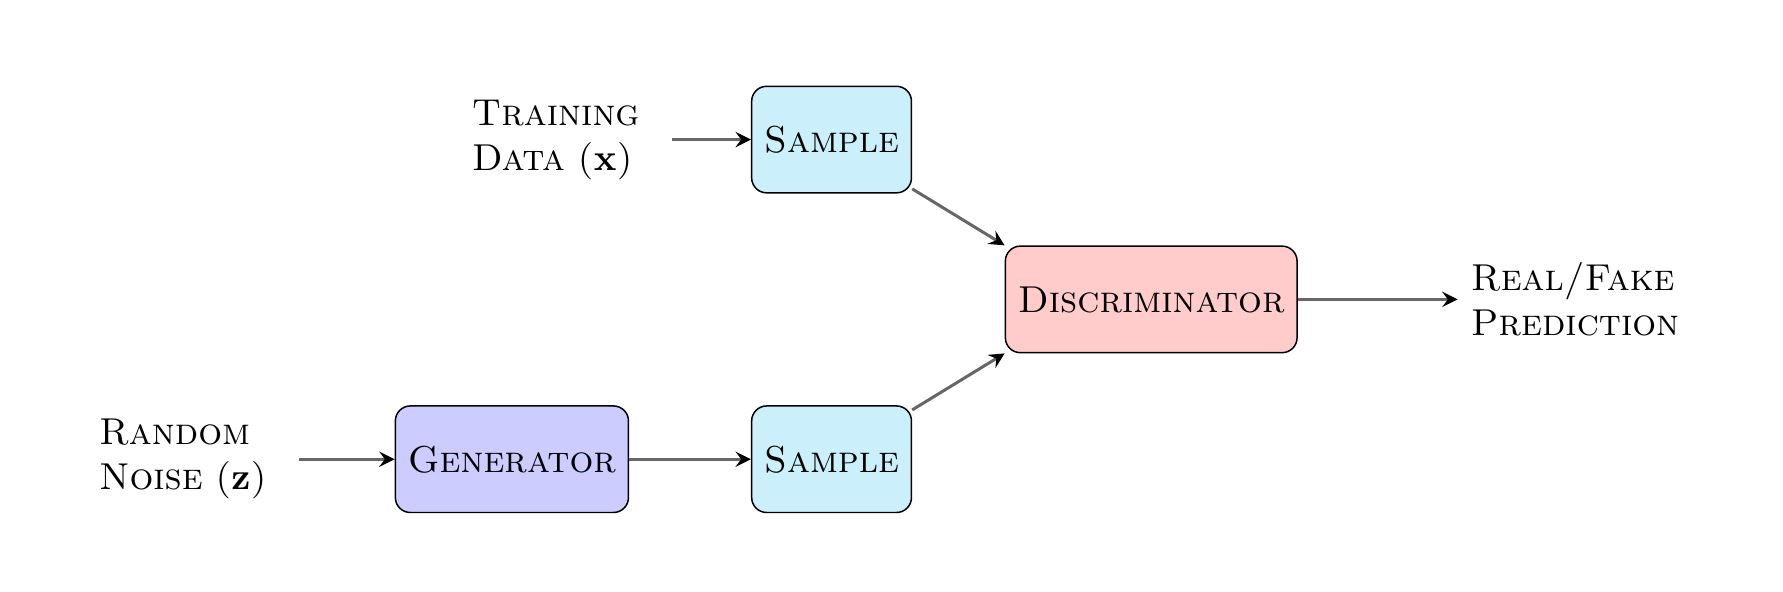

<p align = "center">
Fig.1 - GAN Architecture  
(<a href="https://github.com/JamesAllingham/LaTeX-TikZ-Diagrams">
source
</a>)
</p>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np

In [2]:
EPOCHS = 60
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
Z = 32

In [3]:
# We will be using the mnist digit data.
mnist_dataset = datasets.MNIST(root="minist_data/", download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 296818836.48it/s]

Extracting minist_data/MNIST/raw/train-images-idx3-ubyte.gz to minist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105703048.71it/s]


Extracting minist_data/MNIST/raw/train-labels-idx1-ubyte.gz to minist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 88441901.82it/s]


Extracting minist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to minist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24145156.87it/s]


Extracting minist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to minist_data/MNIST/raw



In [4]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)

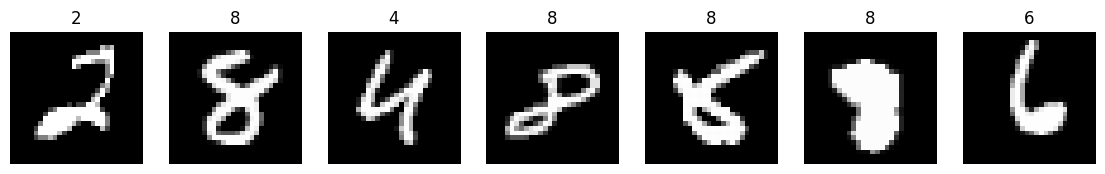

In [5]:
# Visualizing some sample images
figure = plt.figure(figsize=(14, 14))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item()
    img, label = mnist_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

GANs consist of two separate models: generator and discriminator. The generator will take random noise as input and output an image. The discriminator will take an image as input and predict whether its fake or real.

GANs are notoriously hard to train. Considering this, the authors make a few recommendations to make the training more tractable.
 - Initialize weights from N(0, 0.02)
 - Use Tanh as activation
 - Use ADAM as optimzer and set beta1=0.5

We will be using these here.

In [7]:
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)


def weights_init(m):
    """Reinitialize model weights. GAN authors recommend them to be sampled from N(0,0.2)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
  """Generator model"""
  def __init__(self, z):
    super(Generator, self).__init__()
    self.z = z
    self.gen_model = nn.Sequential(
        nn.Linear(z, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),

        nn.Linear(128, 64 * 4 * 4),
        nn.BatchNorm1d(64 * 4 * 4),
        nn.LeakyReLU(),

        Reshape((-1,64,4,4)),

        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Tanh(),
    )

  def forward(self, x):
    x = self.gen_model(x)
    return x


class Discriminator(nn.Module):
  """Discriminator model"""
  def __init__(self):
    super(Discriminator, self).__init__()
    self.disc_model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Flatten(1,-1),
        nn.Linear(64 * 4 * 4, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),

        nn.Linear(128, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    x = self.disc_model(x)
    return x


generator = Generator(z=Z)
generator.apply(weights_init)
generator.to(device)

discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

Discriminator(
  (disc_model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=128, out_features=1, bias=True)
    (14): Sigmoid()
  )
)

In [8]:
# Generator summary
summary(generator, (Z,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,224
       BatchNorm1d-2                  [-1, 128]             256
         LeakyReLU-3                  [-1, 128]               0
            Linear-4                 [-1, 1024]         132,096
       BatchNorm1d-5                 [-1, 1024]           2,048
         LeakyReLU-6                 [-1, 1024]               0
           Reshape-7             [-1, 64, 4, 4]               0
   ConvTranspose2d-8             [-1, 32, 7, 7]          18,464
       BatchNorm2d-9             [-1, 32, 7, 7]              64
        LeakyReLU-10             [-1, 32, 7, 7]               0
  ConvTranspose2d-11           [-1, 16, 14, 14]           4,624
      BatchNorm2d-12           [-1, 16, 14, 14]              32
        LeakyReLU-13           [-1, 16, 14, 14]               0
  ConvTranspose2d-14            [-1, 1,

In [9]:
# Discriminator summary
summary(discriminator, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
         LeakyReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           4,640
       BatchNorm2d-5             [-1, 32, 7, 7]              64
         LeakyReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
         LeakyReLU-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                  [-1, 128]         131,200
      BatchNorm1d-12                  [-1, 128]             256
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                   

In [10]:
# Defining the optimizer and loss function here
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

In [11]:
real_label = 1
fake_label = 0

In [12]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im, cmap="gray")
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

For training, we have to train the two models alternatively to each other. The discriminators goal is to maxime the liklihood of correctly predicting between real and fake images. So, the overall goal of discriminator is to mamximize the following:
$$log(D(x)) + log(1-D(G(z)))$$

The generators goal is to foole the discriminator suc that it predicts its generated images as real. So, the goal of generator is to maximize the following:
$$log(D(G(z)))$$

We will alternatively train both the discriminator and the generator.

Epoch 1/60: : 100%|██████████| 938/938 [00:25<00:00, 37.25it/s, generator_loss=1.31, discriminator_loss=0.737, D(x)=0.688, D(G(z1))=0.295, D(G(z2))=0.276]


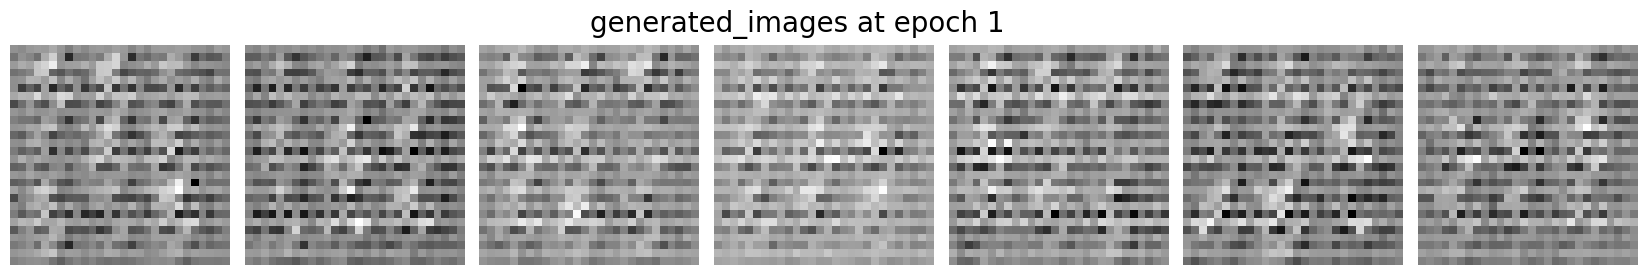

Epoch 2/60: : 100%|██████████| 938/938 [00:25<00:00, 36.41it/s, generator_loss=2.06, discriminator_loss=1.25, D(x)=0.385, D(G(z1))=0.143, D(G(z2))=0.133]


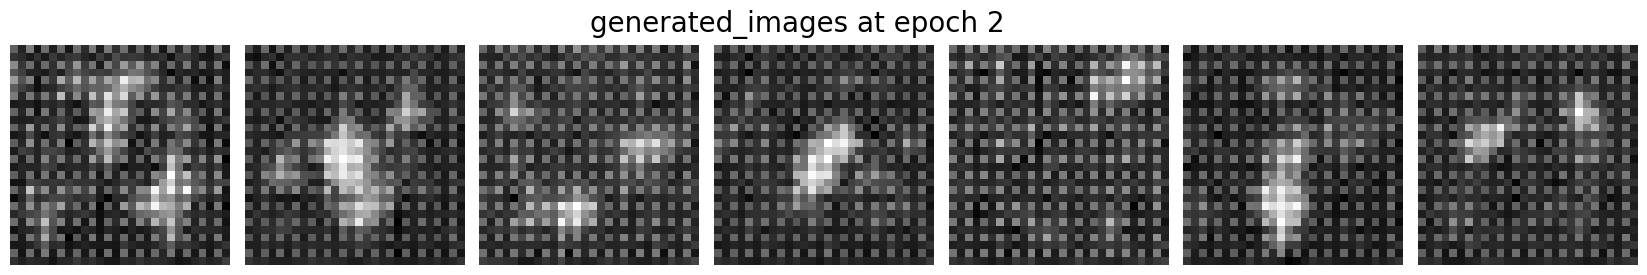

Epoch 3/60: : 100%|██████████| 938/938 [00:26<00:00, 35.82it/s, generator_loss=2.54, discriminator_loss=1.76, D(x)=0.289, D(G(z1))=0.0936, D(G(z2))=0.0886]


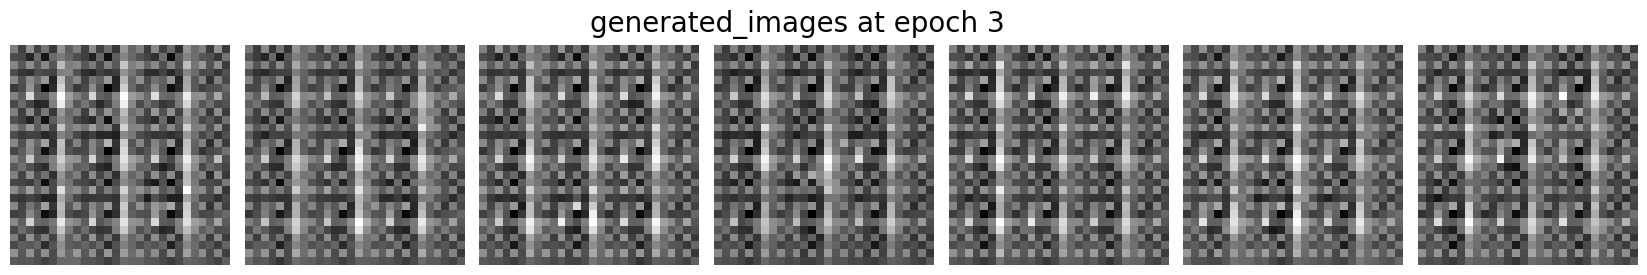

Epoch 4/60: : 100%|██████████| 938/938 [00:30<00:00, 30.67it/s, generator_loss=3.1, discriminator_loss=0.278, D(x)=0.88, D(G(z1))=0.0567, D(G(z2))=0.0488]


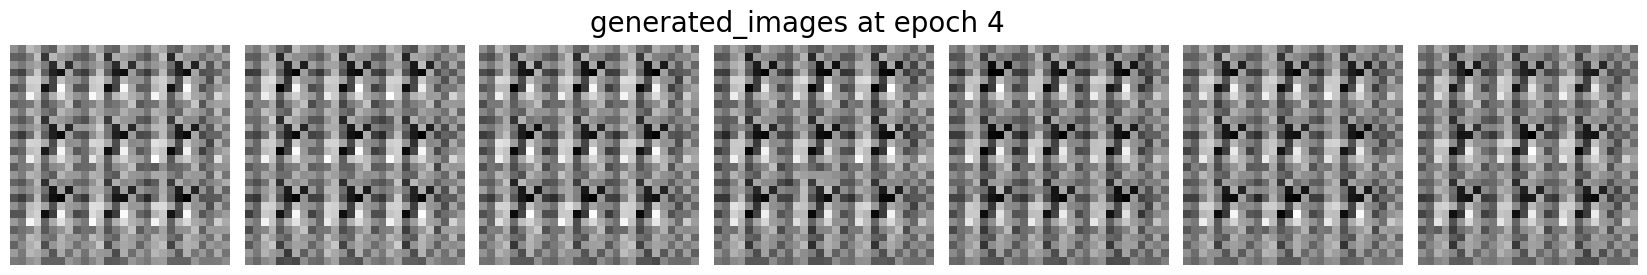

Epoch 5/60: : 100%|██████████| 938/938 [00:26<00:00, 35.53it/s, generator_loss=3.49, discriminator_loss=0.088, D(x)=0.957, D(G(z1))=0.0422, D(G(z2))=0.0338]


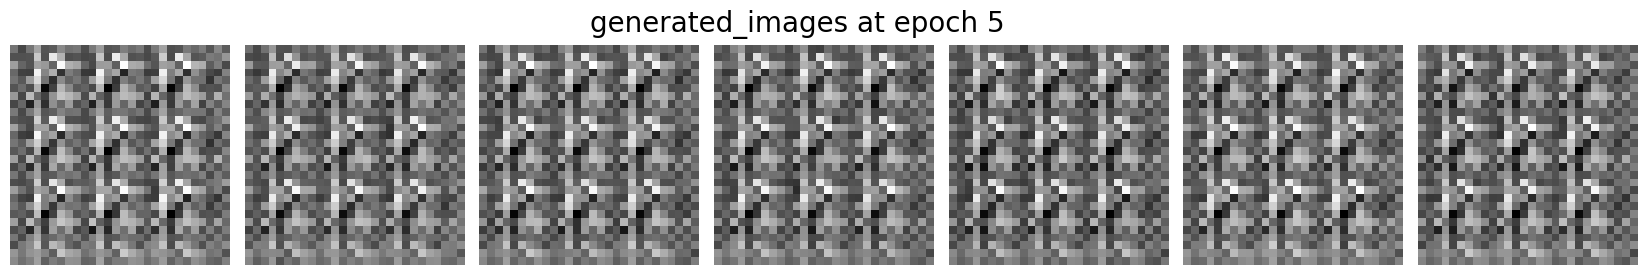

Epoch 6/60: : 100%|██████████| 938/938 [00:27<00:00, 34.35it/s, generator_loss=4.03, discriminator_loss=0.499, D(x)=0.674, D(G(z1))=0.0243, D(G(z2))=0.0201]


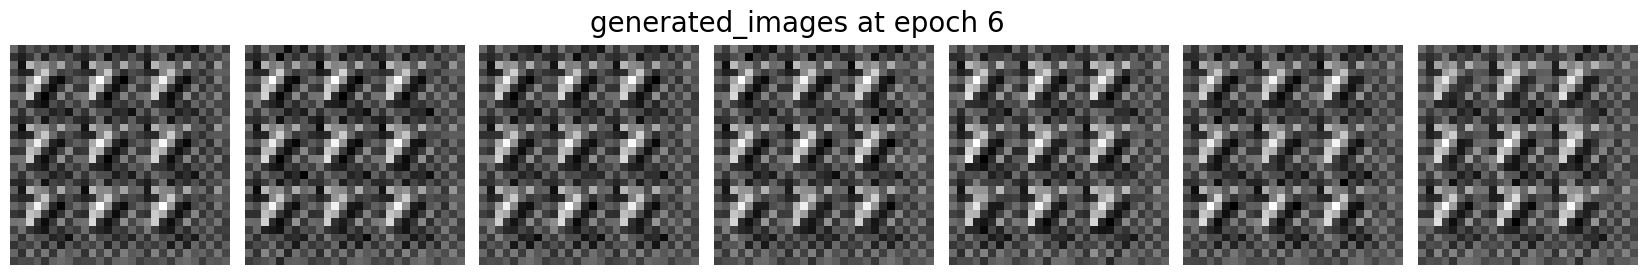

Epoch 7/60: : 100%|██████████| 938/938 [00:28<00:00, 33.33it/s, generator_loss=4.31, discriminator_loss=2.17, D(x)=0.229, D(G(z1))=0.0185, D(G(z2))=0.0173]


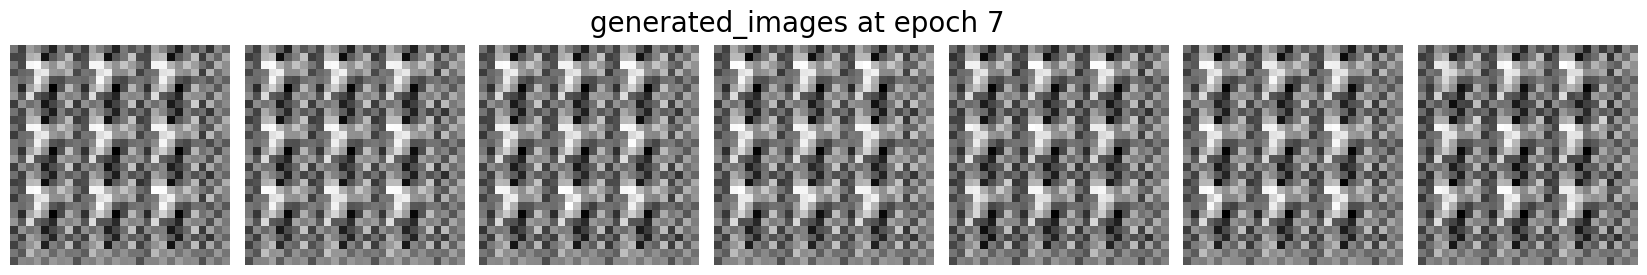

Epoch 8/60: : 100%|██████████| 938/938 [00:27<00:00, 33.82it/s, generator_loss=4.73, discriminator_loss=0.0514, D(x)=0.971, D(G(z1))=0.0139, D(G(z2))=0.0108]


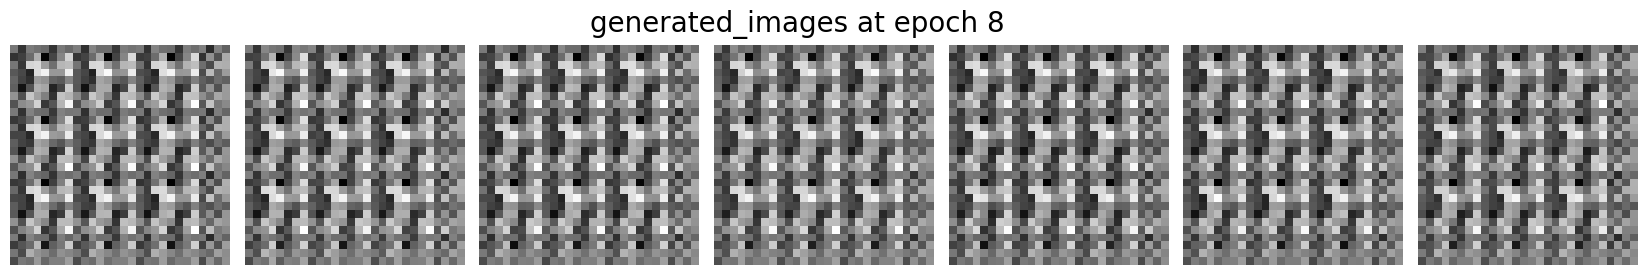

Epoch 9/60: : 100%|██████████| 938/938 [00:27<00:00, 34.09it/s, generator_loss=4.75, discriminator_loss=0.0373, D(x)=0.982, D(G(z1))=0.0183, D(G(z2))=0.0124]


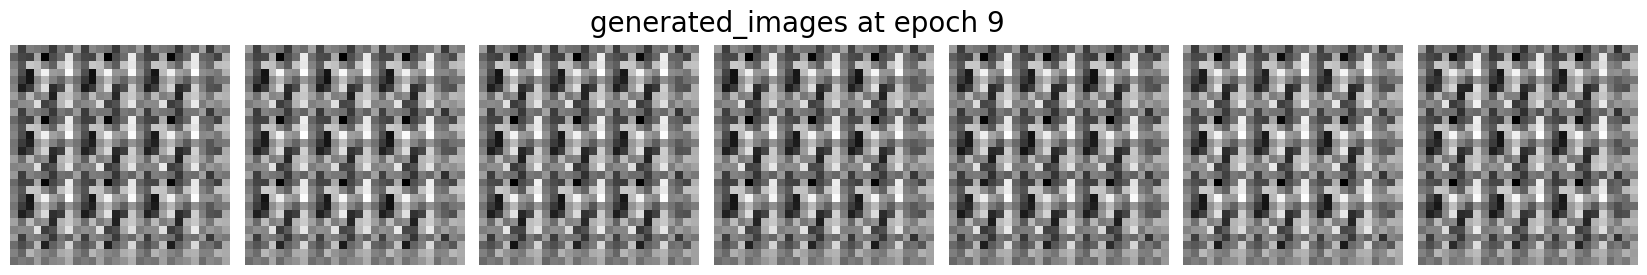

Epoch 10/60: : 100%|██████████| 938/938 [00:29<00:00, 32.15it/s, generator_loss=5.07, discriminator_loss=0.0258, D(x)=0.988, D(G(z1))=0.0132, D(G(z2))=0.0101]


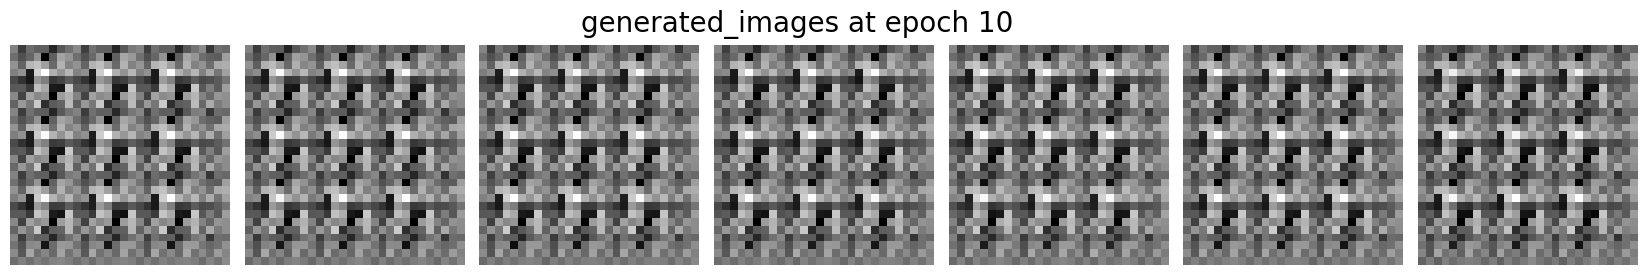

Epoch 11/60: : 100%|██████████| 938/938 [00:28<00:00, 33.22it/s, generator_loss=4.44, discriminator_loss=0.0468, D(x)=0.981, D(G(z1))=0.0271, D(G(z2))=0.0189]


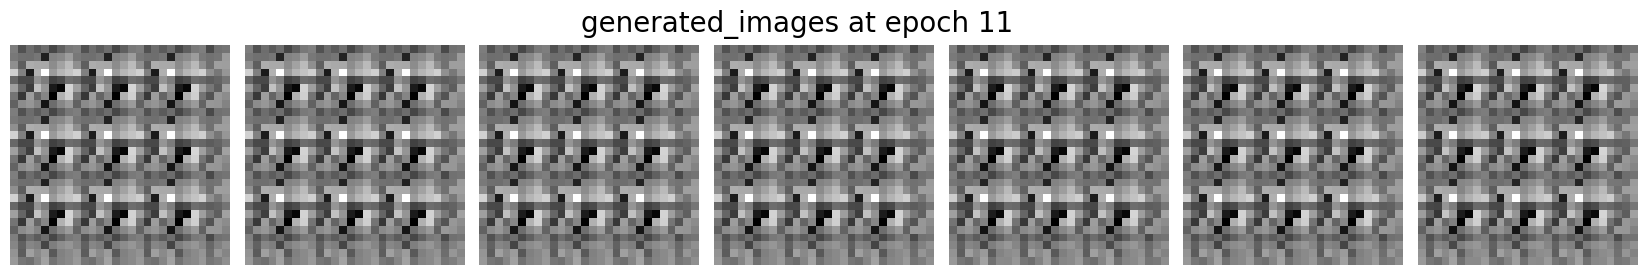

Epoch 12/60: : 100%|██████████| 938/938 [00:28<00:00, 33.29it/s, generator_loss=4.31, discriminator_loss=0.152, D(x)=0.894, D(G(z1))=0.0298, D(G(z2))=0.0208]


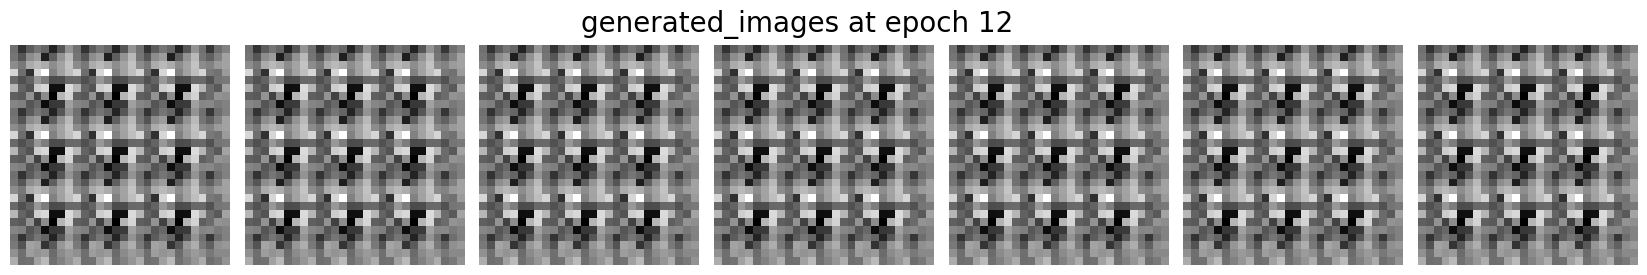

Epoch 13/60: : 100%|██████████| 938/938 [00:31<00:00, 29.60it/s, generator_loss=4.56, discriminator_loss=0.0824, D(x)=0.948, D(G(z1))=0.0264, D(G(z2))=0.0212]


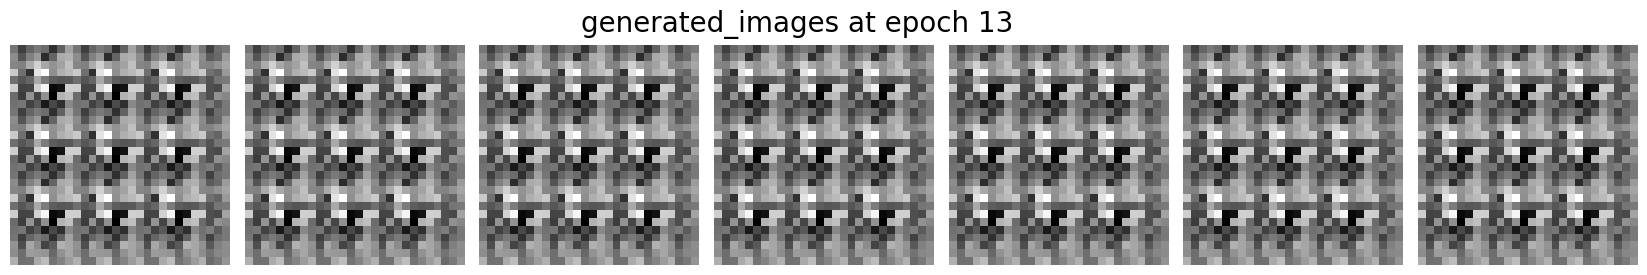

Epoch 14/60: : 100%|██████████| 938/938 [00:28<00:00, 32.87it/s, generator_loss=5.61, discriminator_loss=0.139, D(x)=0.897, D(G(z1))=0.0162, D(G(z2))=0.00856]


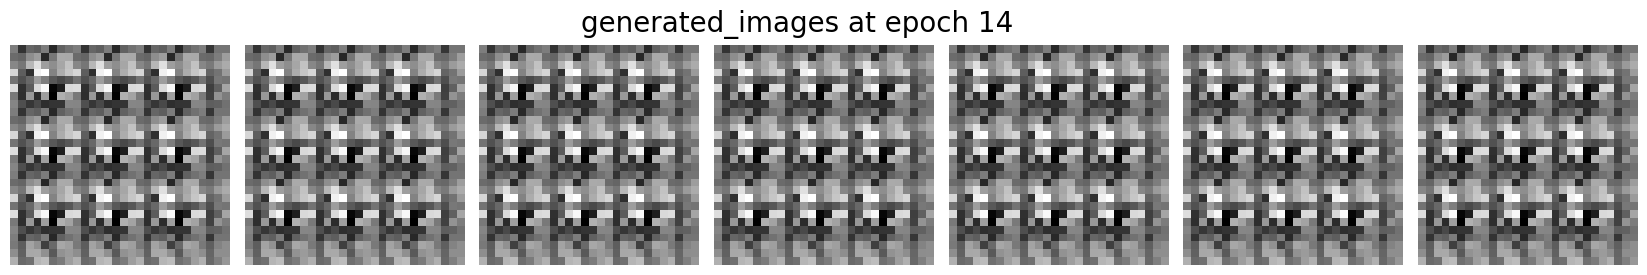

Epoch 15/60: : 100%|██████████| 938/938 [00:28<00:00, 33.05it/s, generator_loss=3.45, discriminator_loss=0.072, D(x)=0.973, D(G(z1))=0.0431, D(G(z2))=0.0382]


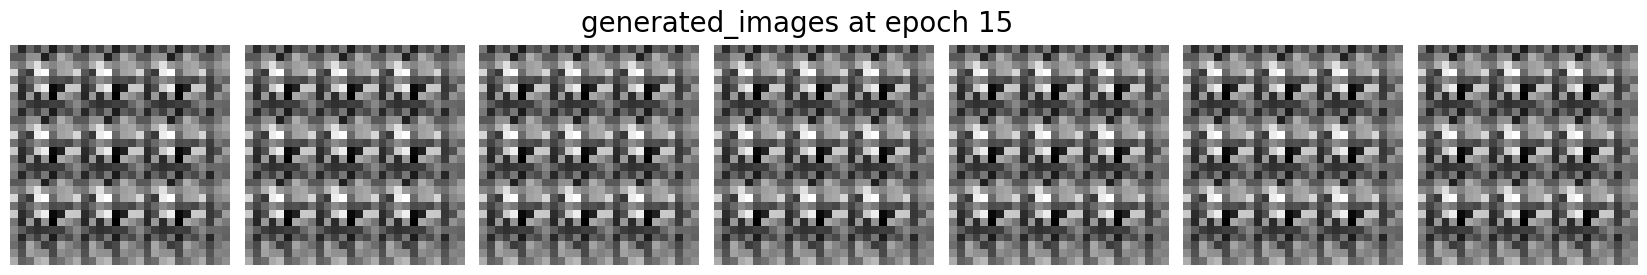

Epoch 16/60: : 100%|██████████| 938/938 [00:29<00:00, 31.81it/s, generator_loss=4.22, discriminator_loss=0.3, D(x)=0.792, D(G(z1))=0.026, D(G(z2))=0.0249]


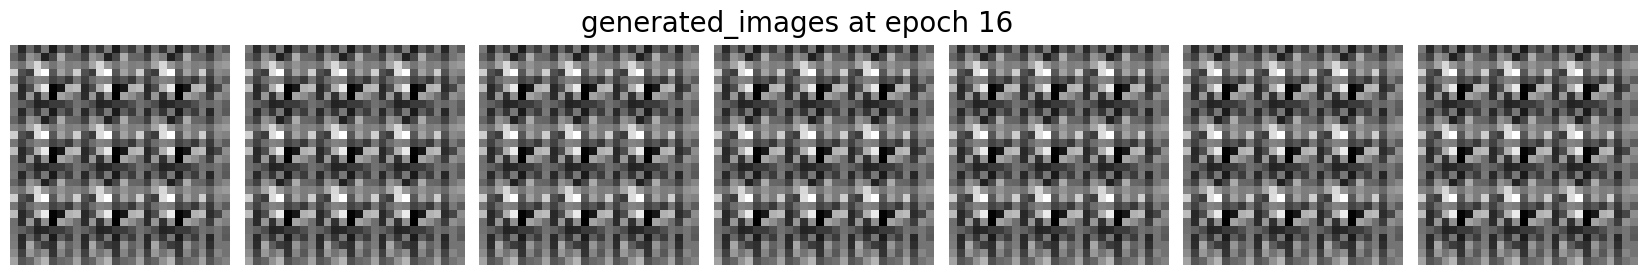

Epoch 17/60: : 100%|██████████| 938/938 [00:28<00:00, 32.75it/s, generator_loss=4.97, discriminator_loss=0.0483, D(x)=0.966, D(G(z1))=0.0123, D(G(z2))=0.012]


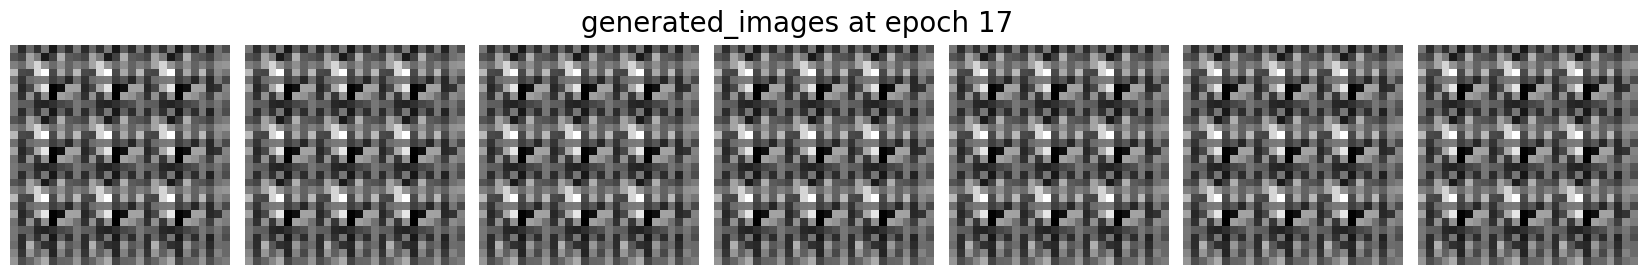

Epoch 18/60: : 100%|██████████| 938/938 [00:28<00:00, 32.48it/s, generator_loss=5.94, discriminator_loss=0.0149, D(x)=0.994, D(G(z1))=0.00899, D(G(z2))=0.00866]


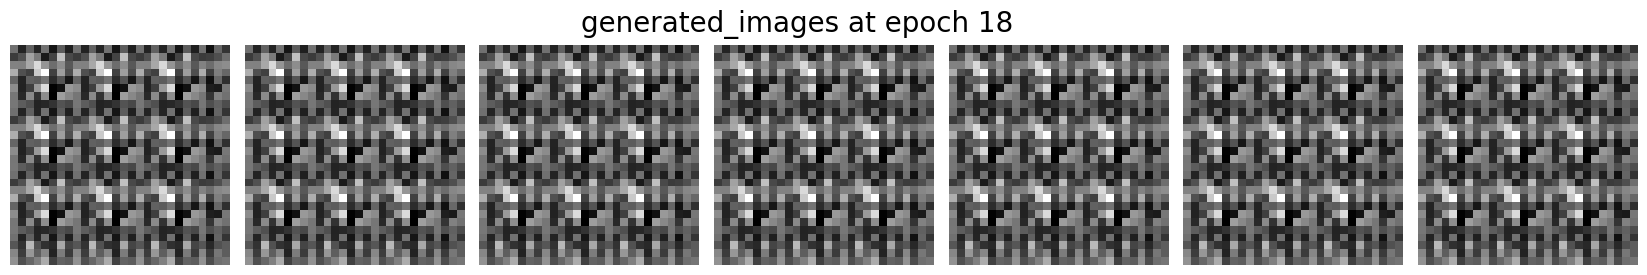

Epoch 19/60: : 100%|██████████| 938/938 [00:28<00:00, 32.51it/s, generator_loss=5.01, discriminator_loss=0.0435, D(x)=0.967, D(G(z1))=0.00821, D(G(z2))=0.00802]


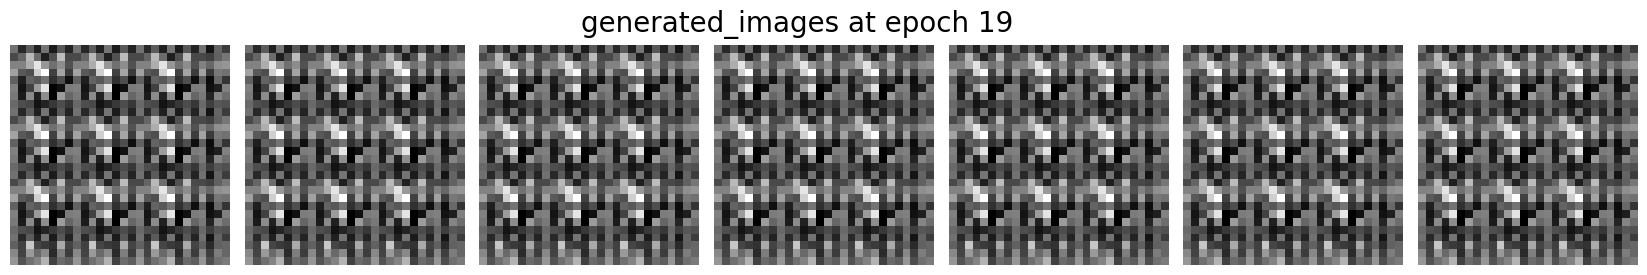

Epoch 20/60: : 100%|██████████| 938/938 [00:28<00:00, 32.84it/s, generator_loss=4.89, discriminator_loss=0.0408, D(x)=0.968, D(G(z1))=0.00763, D(G(z2))=0.0076]


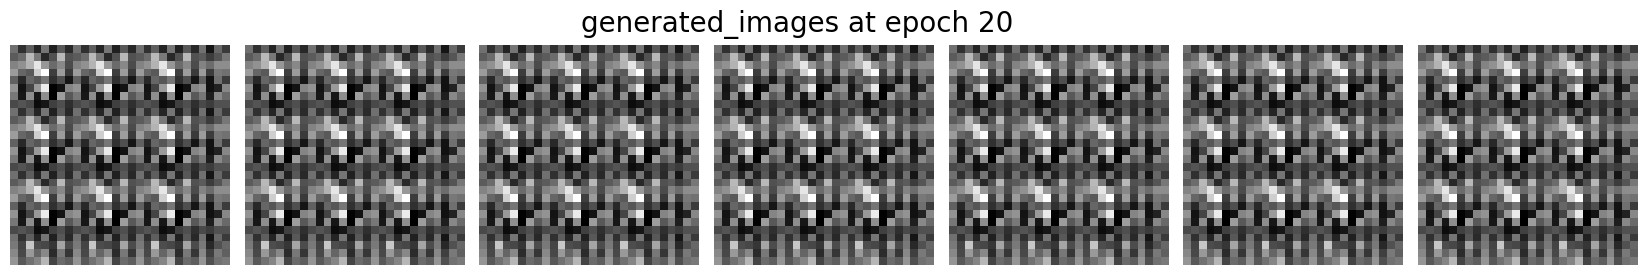

Epoch 21/60: : 100%|██████████| 938/938 [00:29<00:00, 32.23it/s, generator_loss=5.47, discriminator_loss=0.016, D(x)=0.989, D(G(z1))=0.00446, D(G(z2))=0.00437]


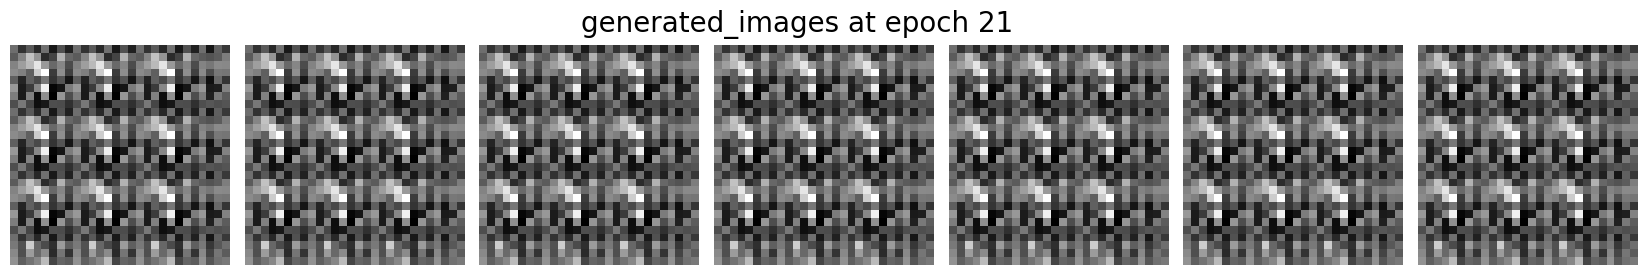

Epoch 22/60: : 100%|██████████| 938/938 [00:29<00:00, 32.31it/s, generator_loss=7.65, discriminator_loss=0.00658, D(x)=0.995, D(G(z1))=0.00114, D(G(z2))=0.0011]


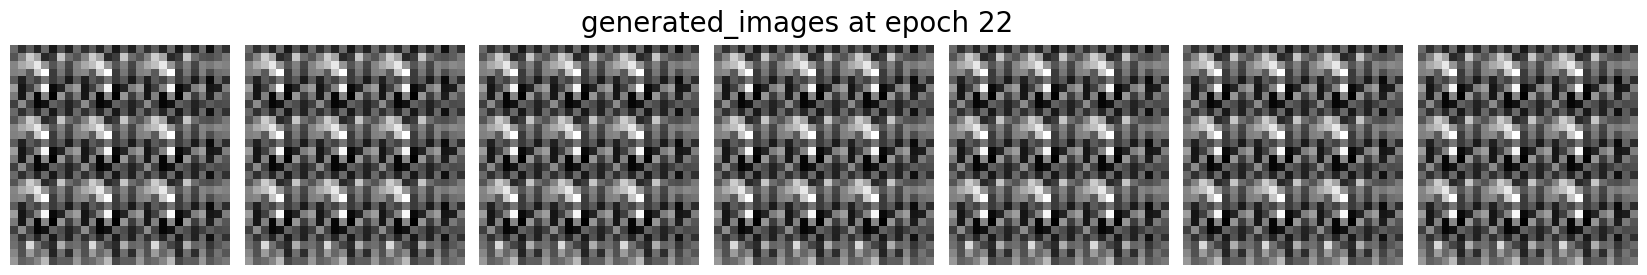

Epoch 23/60: : 100%|██████████| 938/938 [00:28<00:00, 32.55it/s, generator_loss=6.35, discriminator_loss=0.00255, D(x)=1, D(G(z1))=0.00214, D(G(z2))=0.00209]


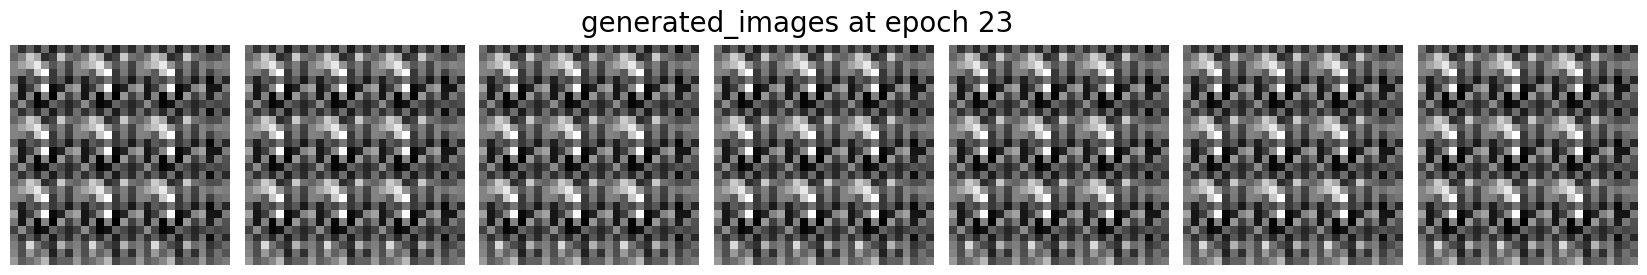

Epoch 24/60: : 100%|██████████| 938/938 [00:29<00:00, 31.44it/s, generator_loss=6.19, discriminator_loss=0.00248, D(x)=1, D(G(z1))=0.00223, D(G(z2))=0.0022]


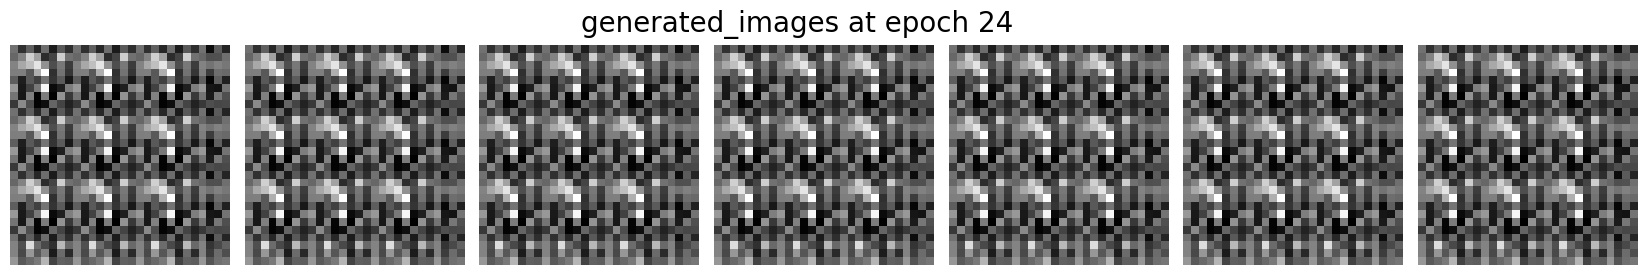

Epoch 25/60: : 100%|██████████| 938/938 [00:29<00:00, 32.06it/s, generator_loss=8.04, discriminator_loss=0.0233, D(x)=0.979, D(G(z1))=0.00061, D(G(z2))=0.000593]


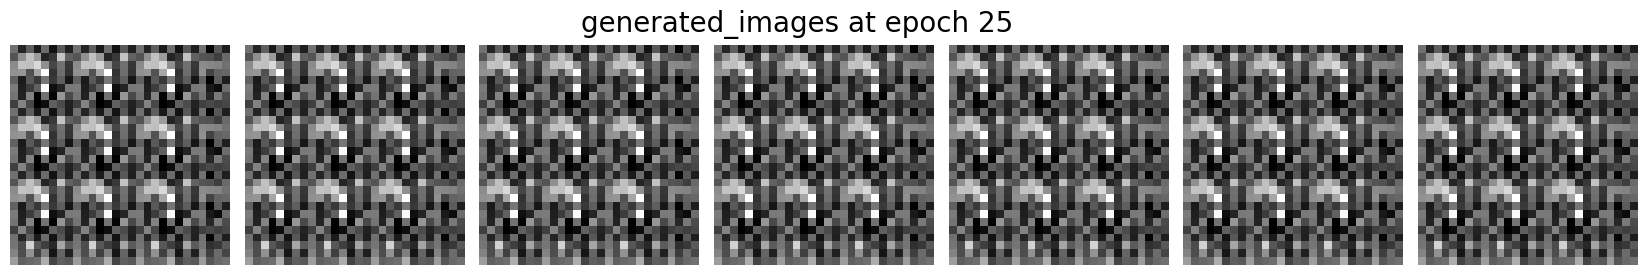

Epoch 26/60: : 100%|██████████| 938/938 [00:29<00:00, 31.43it/s, generator_loss=7.53, discriminator_loss=0.00177, D(x)=0.999, D(G(z1))=0.000752, D(G(z2))=0.000729]


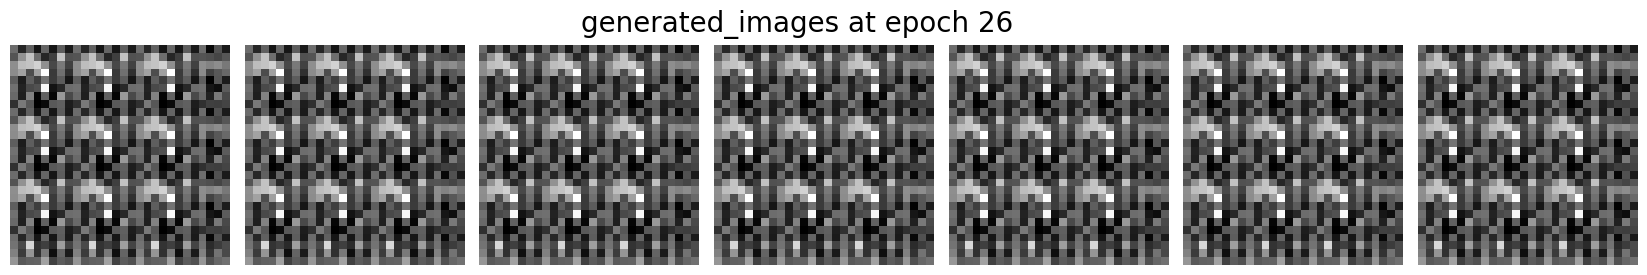

Epoch 27/60: : 100%|██████████| 938/938 [00:29<00:00, 31.42it/s, generator_loss=8.78, discriminator_loss=0.000634, D(x)=1, D(G(z1))=0.000396, D(G(z2))=0.000365]


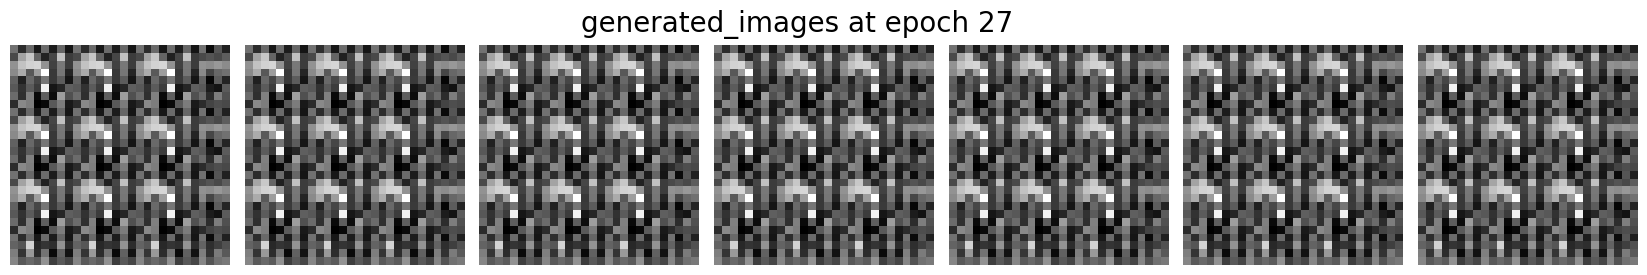

Epoch 28/60: : 100%|██████████| 938/938 [00:29<00:00, 31.50it/s, generator_loss=7.66, discriminator_loss=0.000995, D(x)=0.999, D(G(z1))=0.00048, D(G(z2))=0.000482]


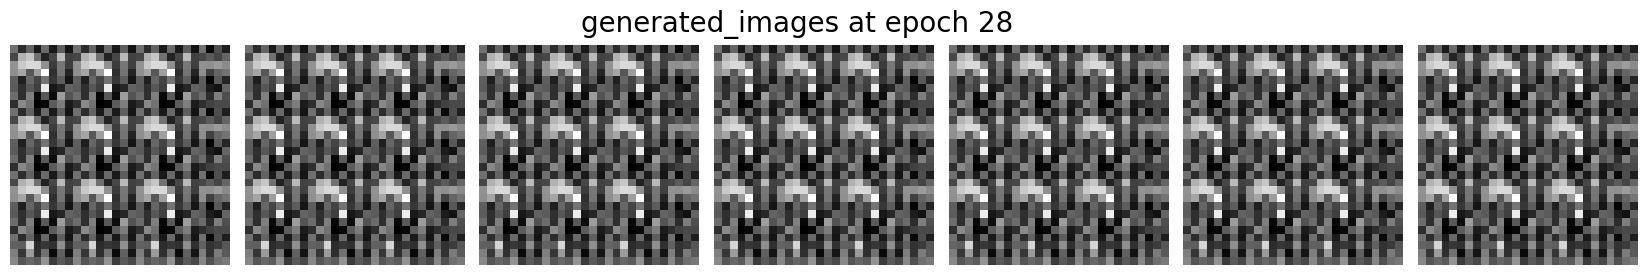

Epoch 29/60: : 100%|██████████| 938/938 [00:28<00:00, 32.70it/s, generator_loss=8.21, discriminator_loss=0.000541, D(x)=1, D(G(z1))=0.000298, D(G(z2))=0.000293]


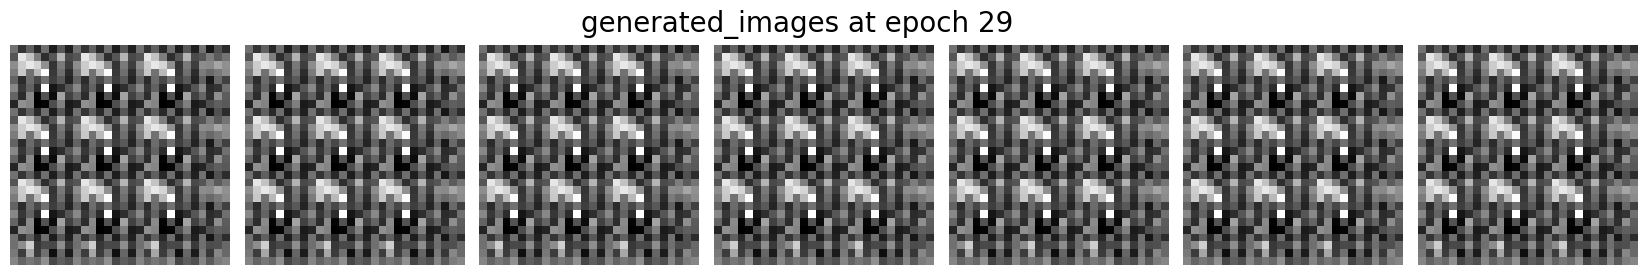

Epoch 30/60: : 100%|██████████| 938/938 [00:29<00:00, 32.33it/s, generator_loss=7.38, discriminator_loss=0.00697, D(x)=0.995, D(G(z1))=0.00143, D(G(z2))=0.00097]


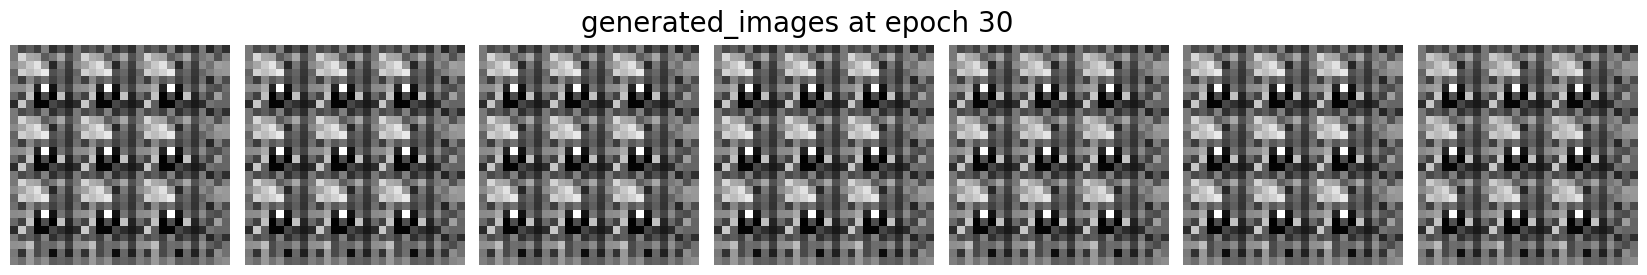

Epoch 31/60: : 100%|██████████| 938/938 [00:29<00:00, 31.52it/s, generator_loss=6.78, discriminator_loss=0.0117, D(x)=0.99, D(G(z1))=0.00149, D(G(z2))=0.00141]


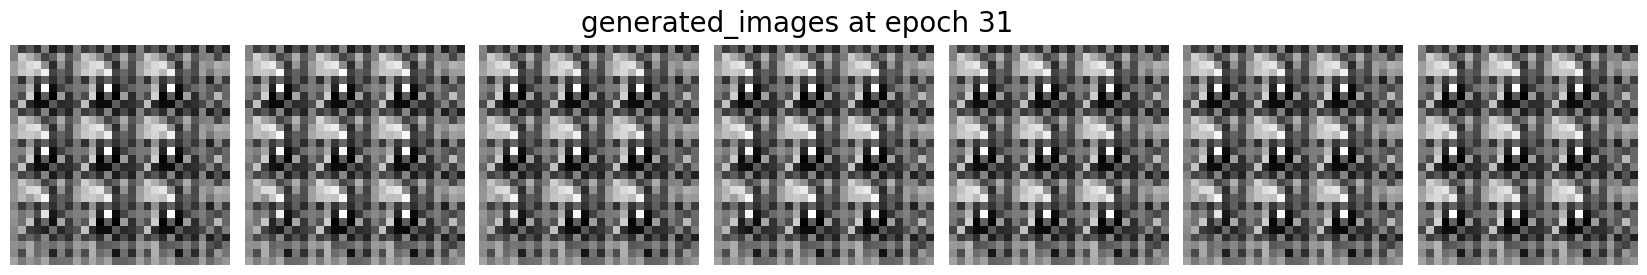

Epoch 32/60: : 100%|██████████| 938/938 [00:29<00:00, 31.46it/s, generator_loss=6.95, discriminator_loss=0.00376, D(x)=0.998, D(G(z1))=0.00195, D(G(z2))=0.0017]


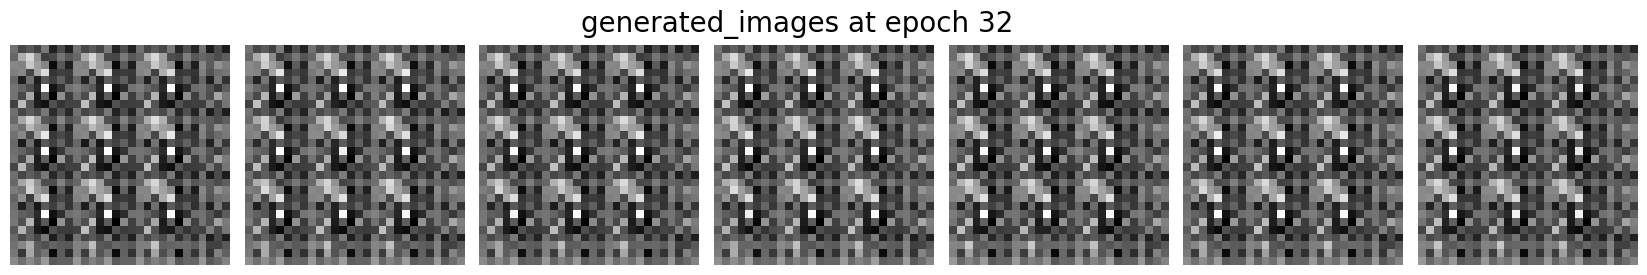

Epoch 33/60: : 100%|██████████| 938/938 [00:30<00:00, 30.39it/s, generator_loss=6.72, discriminator_loss=0.0134, D(x)=0.992, D(G(z1))=0.00459, D(G(z2))=0.00288]


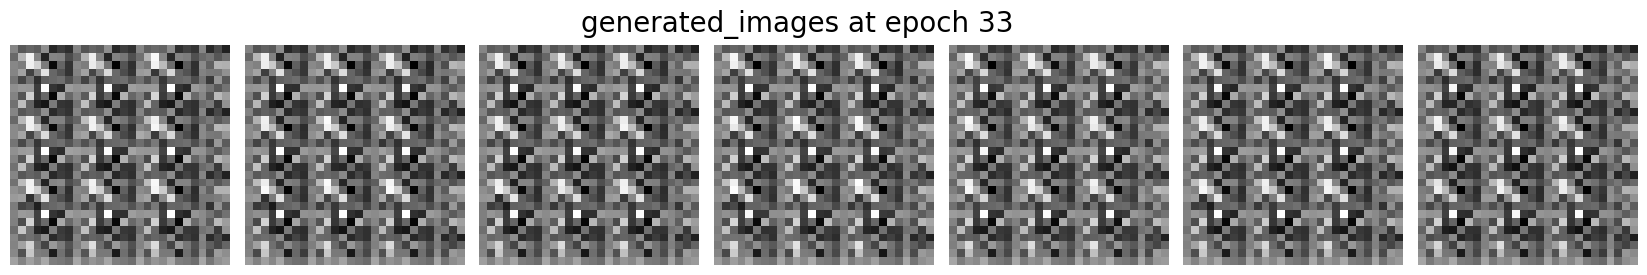

Epoch 34/60: : 100%|██████████| 938/938 [00:32<00:00, 29.26it/s, generator_loss=9.05, discriminator_loss=0.0179, D(x)=0.989, D(G(z1))=0.00647, D(G(z2))=0.00763]


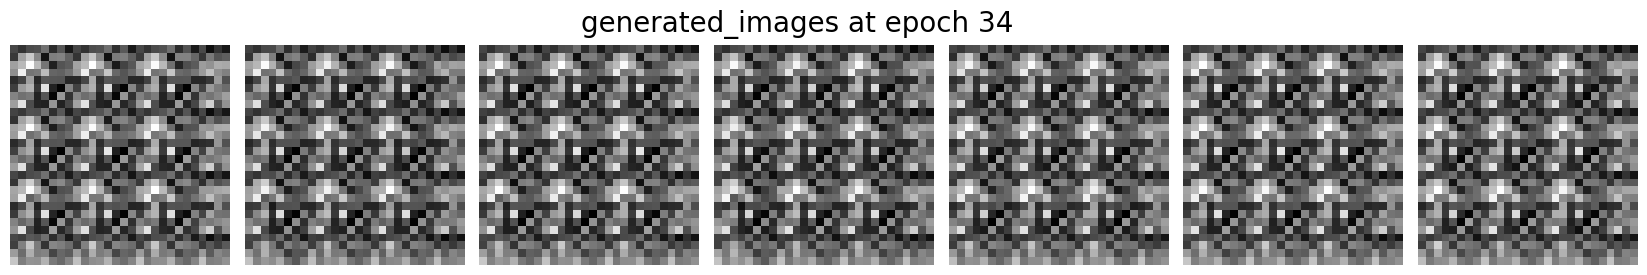

Epoch 35/60: : 100%|██████████| 938/938 [00:30<00:00, 31.07it/s, generator_loss=6.63, discriminator_loss=0.0193, D(x)=0.985, D(G(z1))=0.00382, D(G(z2))=0.00256]


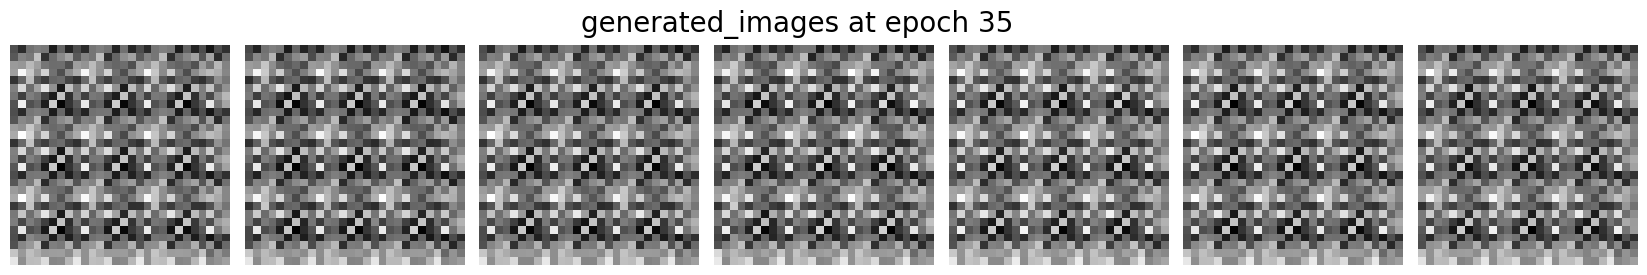

Epoch 36/60: : 100%|██████████| 938/938 [00:30<00:00, 30.42it/s, generator_loss=7.66, discriminator_loss=1.51, D(x)=0.518, D(G(z1))=0.00236, D(G(z2))=0.00106]


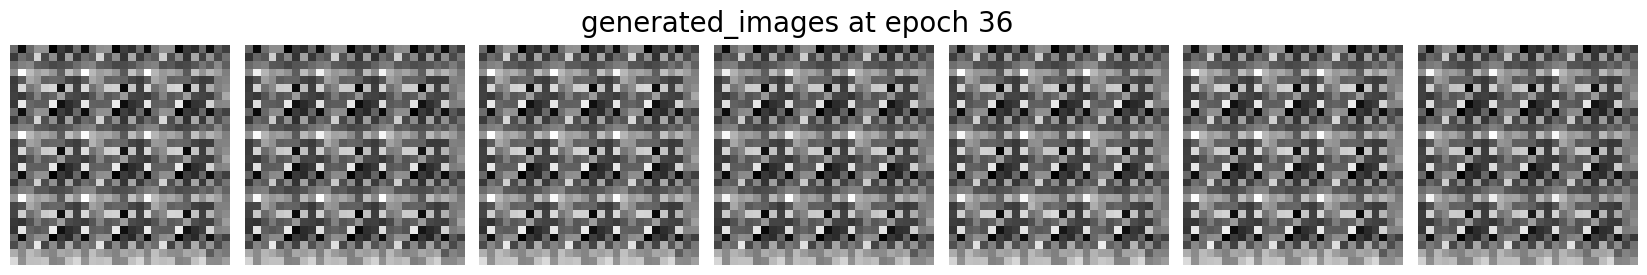

Epoch 37/60: : 100%|██████████| 938/938 [00:30<00:00, 30.44it/s, generator_loss=6.36, discriminator_loss=0.411, D(x)=0.711, D(G(z1))=0.00282, D(G(z2))=0.00228]


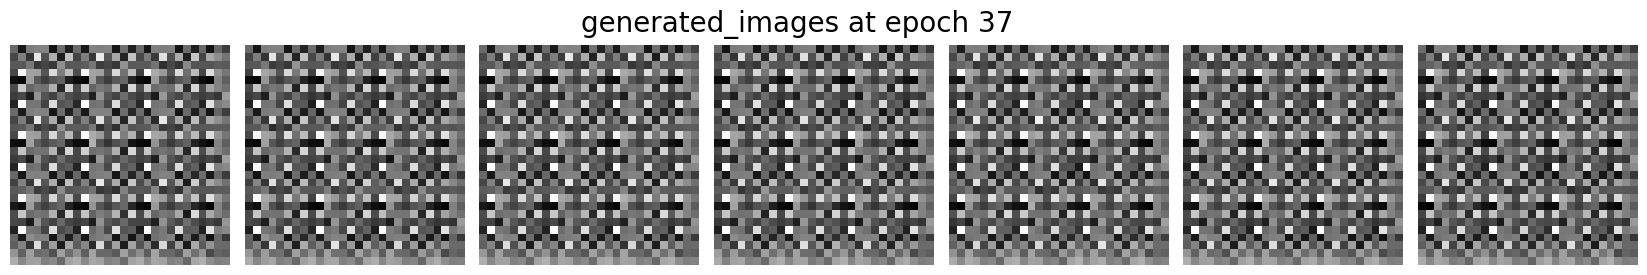

Epoch 38/60: : 100%|██████████| 938/938 [00:31<00:00, 29.76it/s, generator_loss=5.21, discriminator_loss=0.256, D(x)=0.844, D(G(z1))=0.0178, D(G(z2))=0.0092]


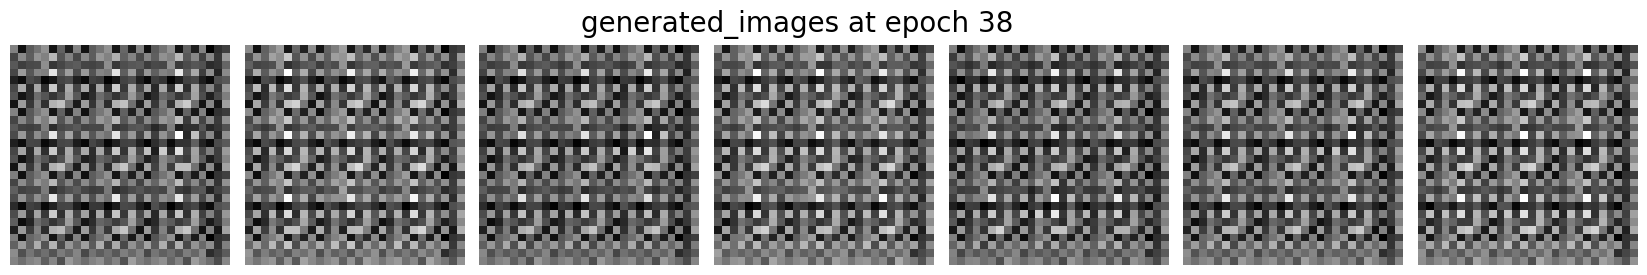

Epoch 39/60: : 100%|██████████| 938/938 [00:30<00:00, 30.41it/s, generator_loss=4.51, discriminator_loss=0.0503, D(x)=0.97, D(G(z1))=0.0184, D(G(z2))=0.0157]


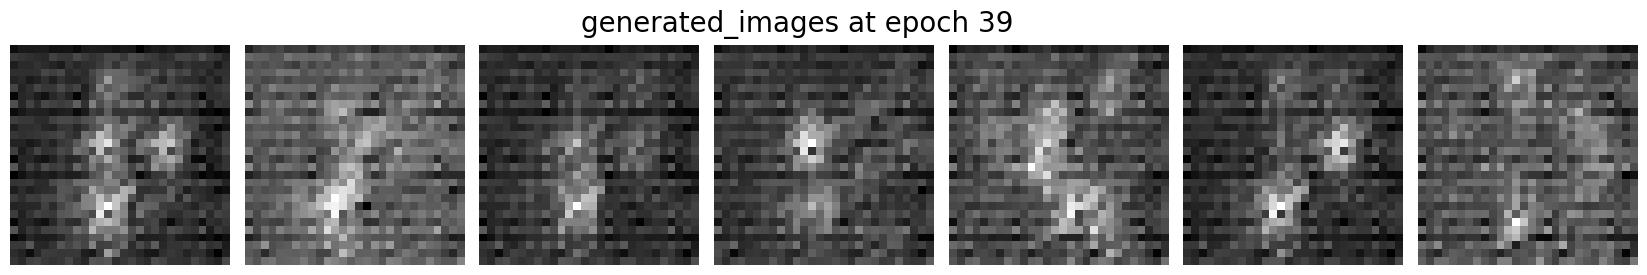

Epoch 40/60: : 100%|██████████| 938/938 [00:30<00:00, 31.13it/s, generator_loss=4.63, discriminator_loss=0.0311, D(x)=0.992, D(G(z1))=0.0228, D(G(z2))=0.0163]


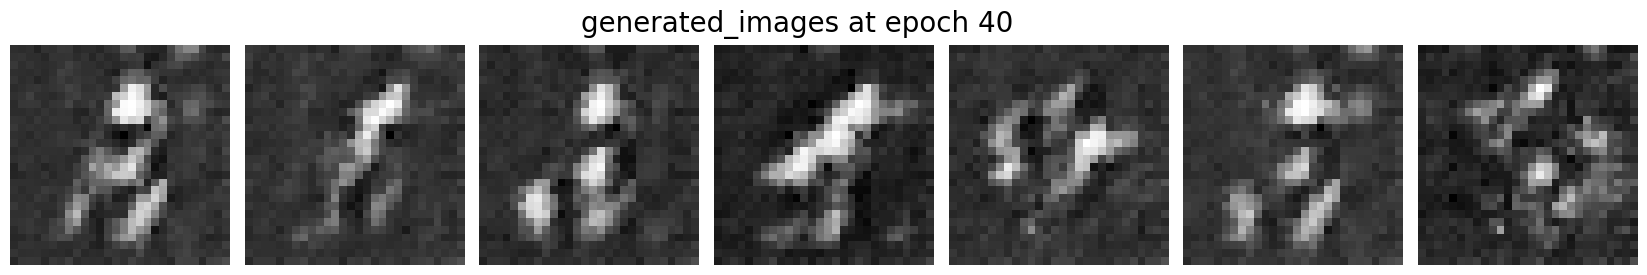

Epoch 41/60: : 100%|██████████| 938/938 [00:30<00:00, 31.26it/s, generator_loss=0.885, discriminator_loss=3.53, D(x)=0.213, D(G(z1))=0.0431, D(G(z2))=0.543]


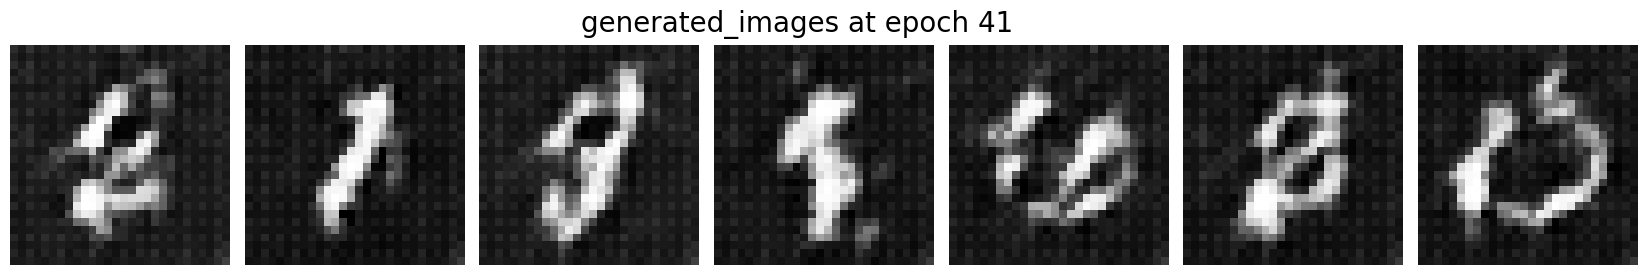

Epoch 42/60: : 100%|██████████| 938/938 [00:31<00:00, 29.38it/s, generator_loss=4.06, discriminator_loss=0.0602, D(x)=0.985, D(G(z1))=0.0428, D(G(z2))=0.0315]


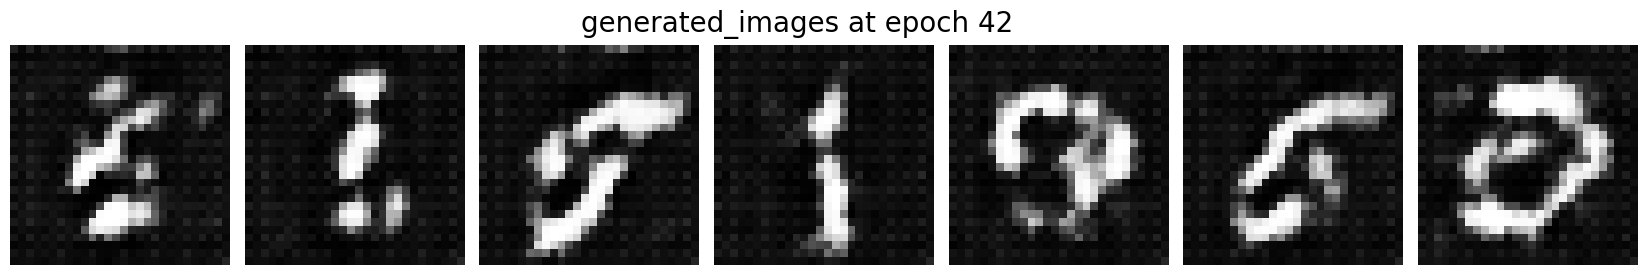

Epoch 43/60: : 100%|██████████| 938/938 [00:31<00:00, 30.02it/s, generator_loss=4.44, discriminator_loss=0.0688, D(x)=0.971, D(G(z1))=0.0344, D(G(z2))=0.0228]


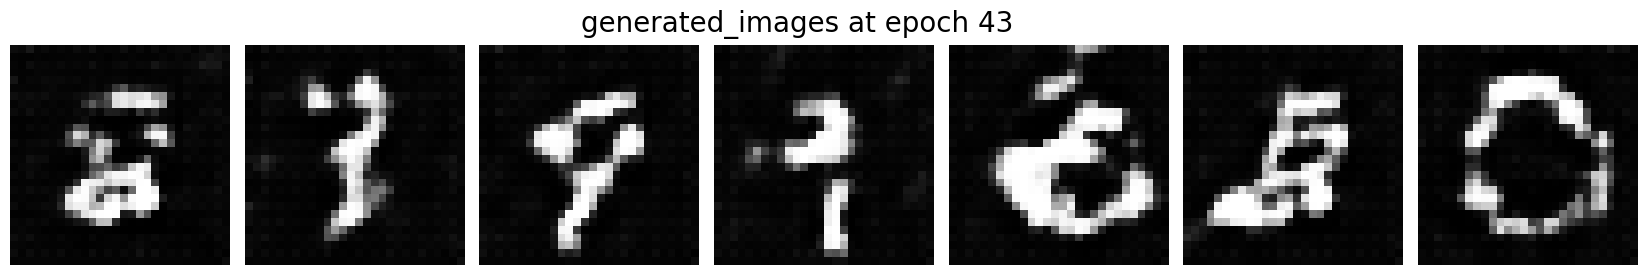

Epoch 44/60: : 100%|██████████| 938/938 [00:30<00:00, 30.92it/s, generator_loss=4.35, discriminator_loss=0.186, D(x)=0.975, D(G(z1))=0.131, D(G(z2))=0.0253]


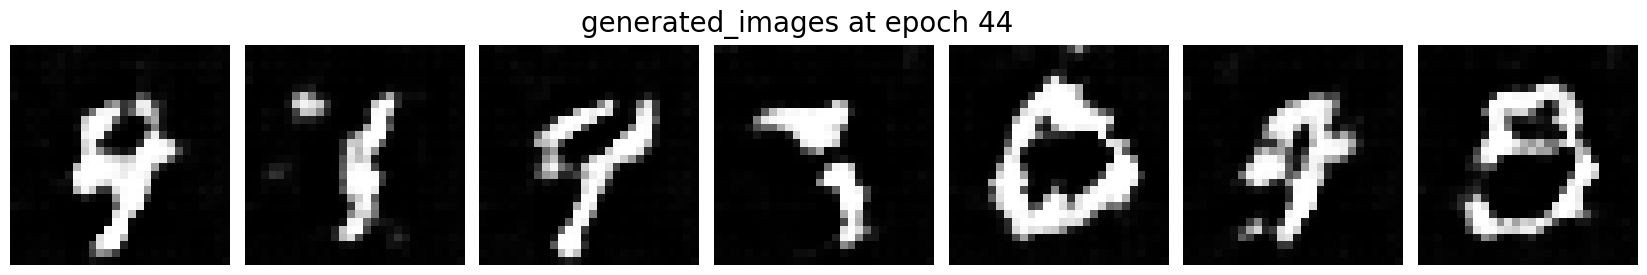

Epoch 45/60: : 100%|██████████| 938/938 [00:30<00:00, 30.93it/s, generator_loss=2.4, discriminator_loss=0.533, D(x)=0.711, D(G(z1))=0.054, D(G(z2))=0.137]


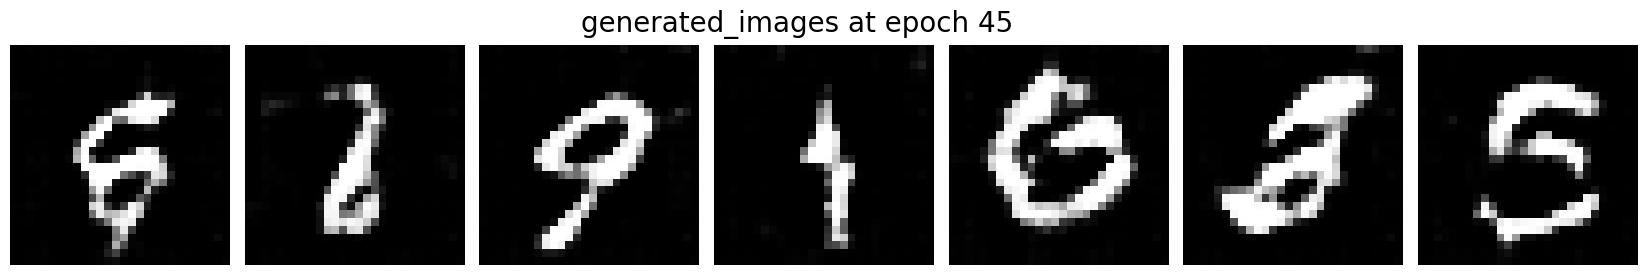

Epoch 46/60: : 100%|██████████| 938/938 [00:30<00:00, 31.08it/s, generator_loss=4, discriminator_loss=0.333, D(x)=0.799, D(G(z1))=0.0302, D(G(z2))=0.0302]


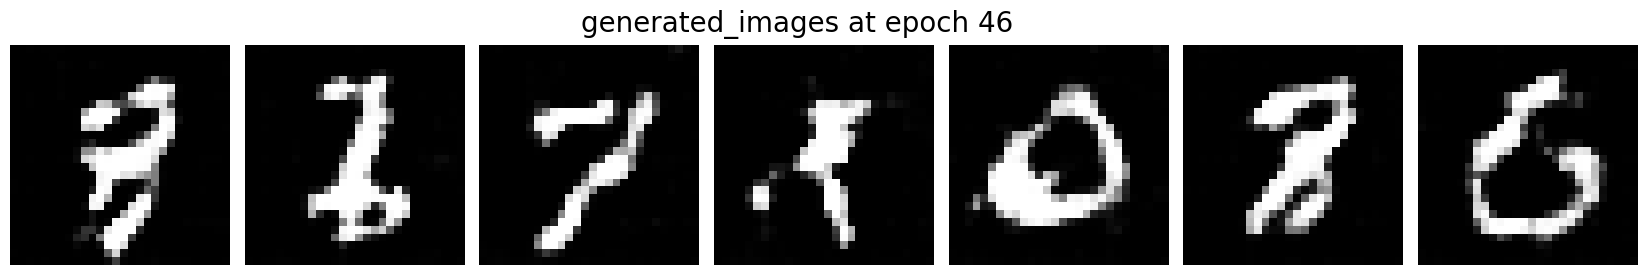

Epoch 47/60: : 100%|██████████| 938/938 [00:29<00:00, 31.54it/s, generator_loss=2.34, discriminator_loss=0.276, D(x)=0.875, D(G(z1))=0.106, D(G(z2))=0.129]


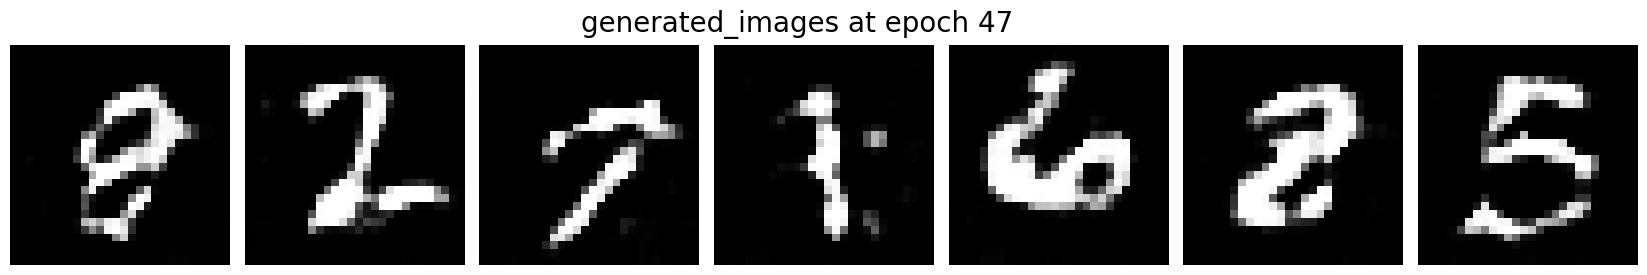

Epoch 48/60: : 100%|██████████| 938/938 [00:29<00:00, 31.45it/s, generator_loss=3.83, discriminator_loss=0.211, D(x)=0.894, D(G(z1))=0.0537, D(G(z2))=0.0458]


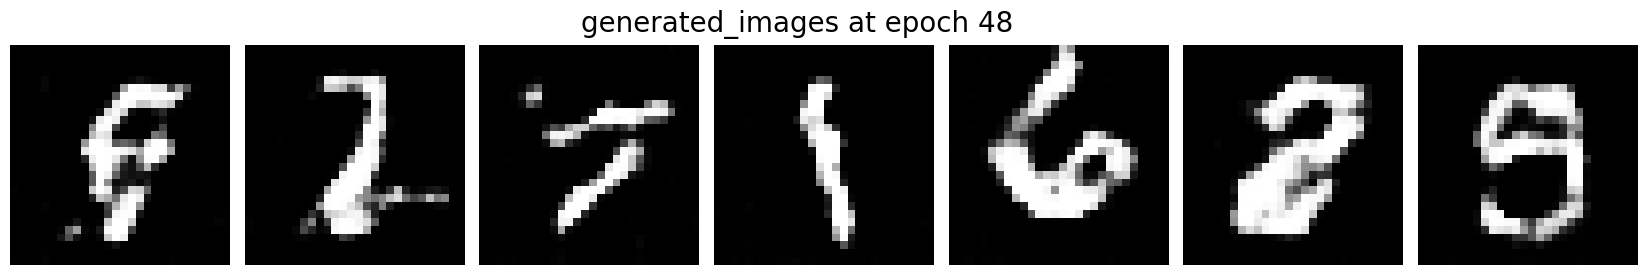

Epoch 49/60: : 100%|██████████| 938/938 [00:30<00:00, 30.75it/s, generator_loss=2.37, discriminator_loss=0.406, D(x)=0.796, D(G(z1))=0.0594, D(G(z2))=0.137]


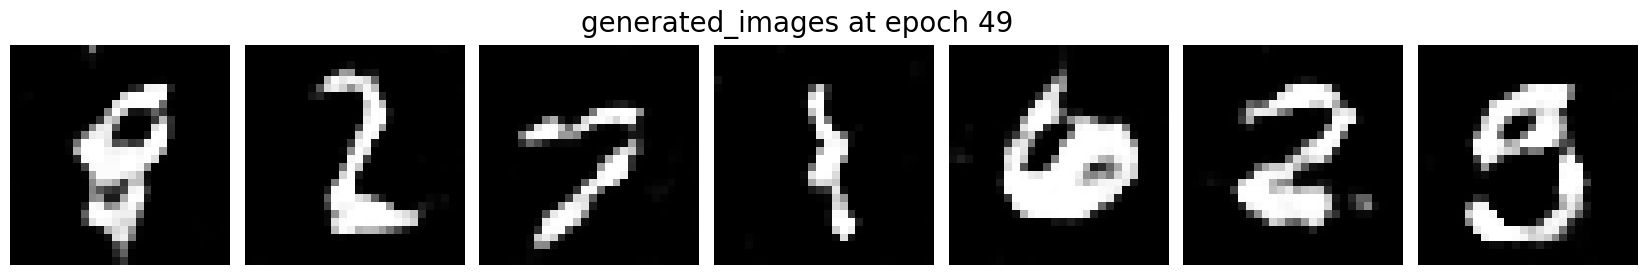

Epoch 50/60: : 100%|██████████| 938/938 [00:31<00:00, 30.07it/s, generator_loss=3.52, discriminator_loss=0.141, D(x)=0.943, D(G(z1))=0.0716, D(G(z2))=0.0493]


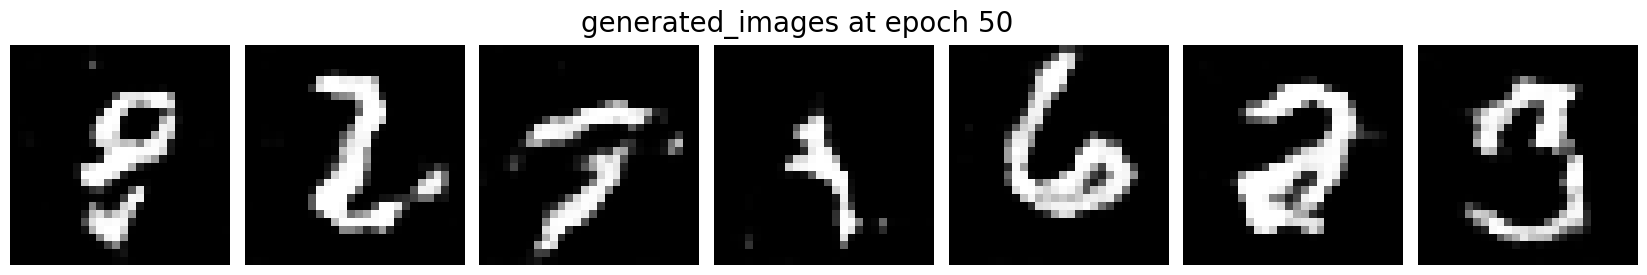

Epoch 51/60: : 100%|██████████| 938/938 [00:29<00:00, 31.40it/s, generator_loss=4.54, discriminator_loss=0.111, D(x)=0.984, D(G(z1))=0.0638, D(G(z2))=0.0285]


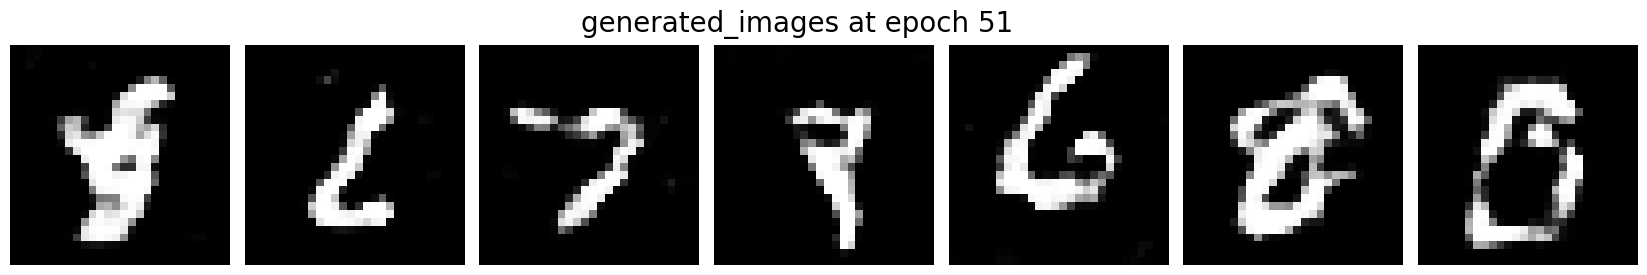

Epoch 52/60: : 100%|██████████| 938/938 [00:30<00:00, 30.95it/s, generator_loss=3.48, discriminator_loss=0.326, D(x)=0.796, D(G(z1))=0.0334, D(G(z2))=0.062]


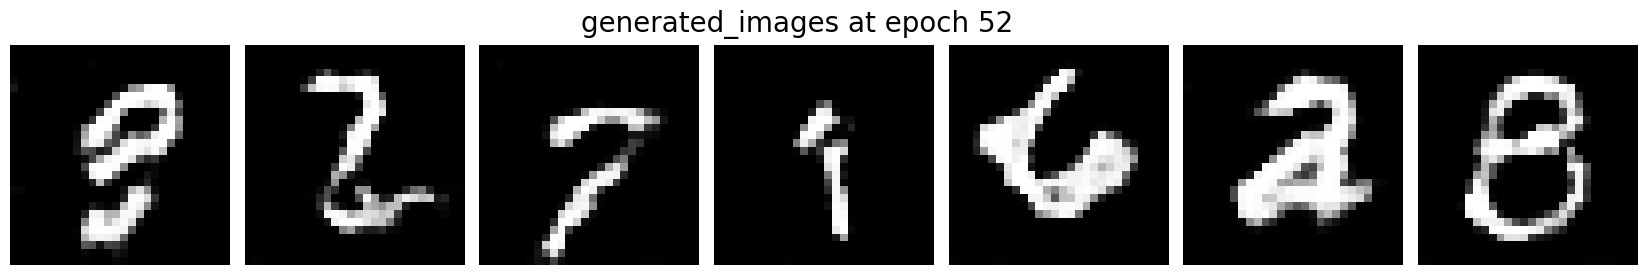

Epoch 53/60: : 100%|██████████| 938/938 [00:29<00:00, 32.25it/s, generator_loss=3.81, discriminator_loss=0.298, D(x)=0.951, D(G(z1))=0.189, D(G(z2))=0.0347]


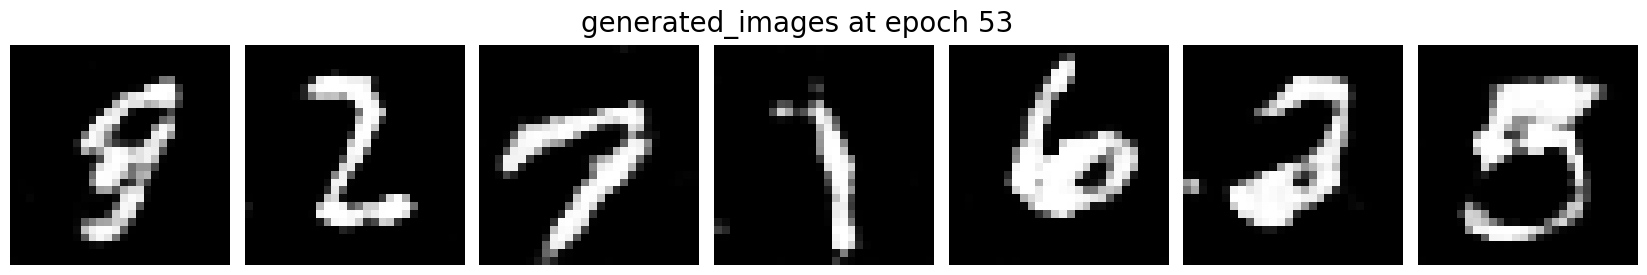

Epoch 54/60: : 100%|██████████| 938/938 [00:29<00:00, 31.53it/s, generator_loss=2.18, discriminator_loss=0.387, D(x)=0.808, D(G(z1))=0.096, D(G(z2))=0.151]


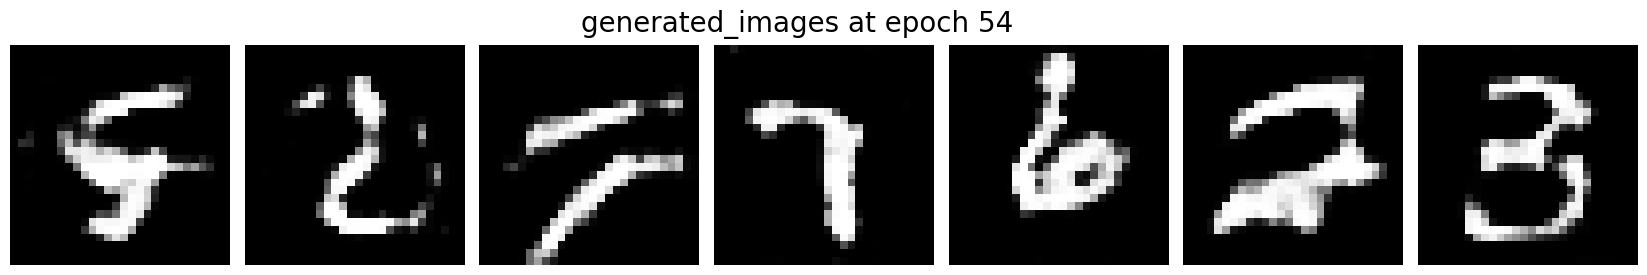

Epoch 55/60: : 100%|██████████| 938/938 [00:29<00:00, 31.42it/s, generator_loss=4.66, discriminator_loss=0.169, D(x)=0.877, D(G(z1))=0.0194, D(G(z2))=0.0225]


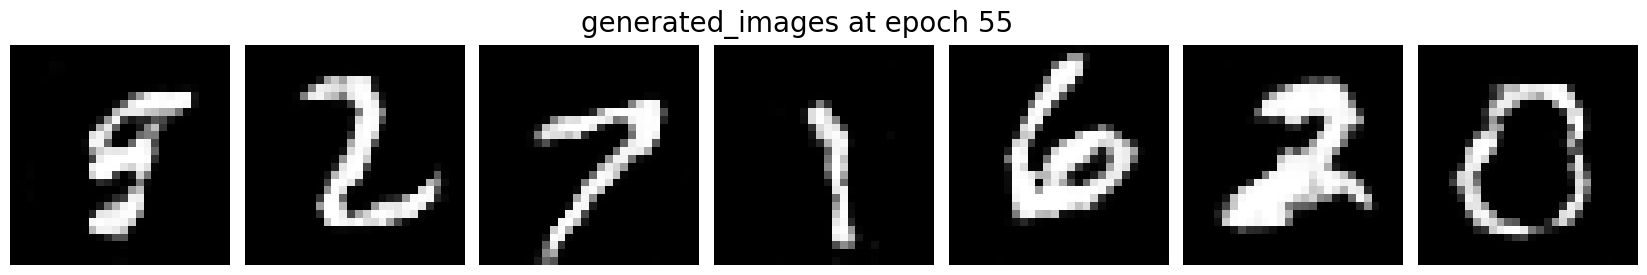

Epoch 56/60: : 100%|██████████| 938/938 [00:30<00:00, 31.09it/s, generator_loss=4.15, discriminator_loss=0.165, D(x)=0.907, D(G(z1))=0.0416, D(G(z2))=0.0399]


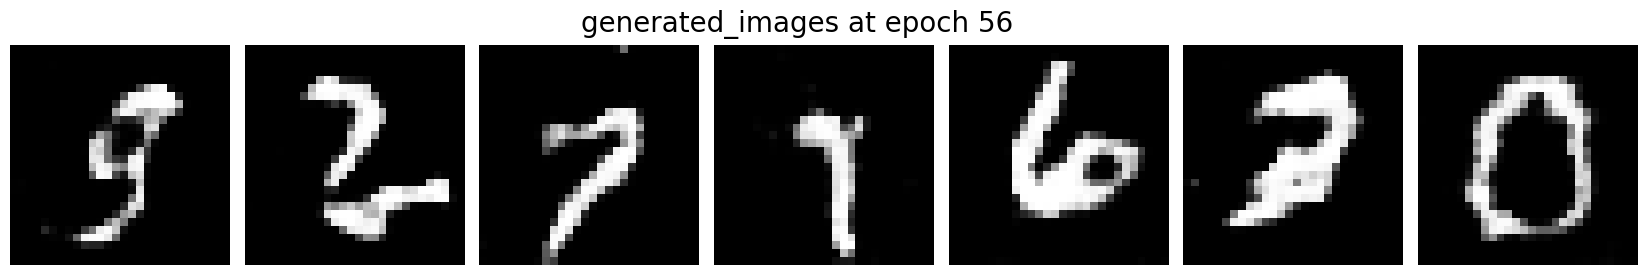

Epoch 57/60: : 100%|██████████| 938/938 [00:29<00:00, 31.55it/s, generator_loss=4.79, discriminator_loss=0.198, D(x)=0.863, D(G(z1))=0.0163, D(G(z2))=0.0174]


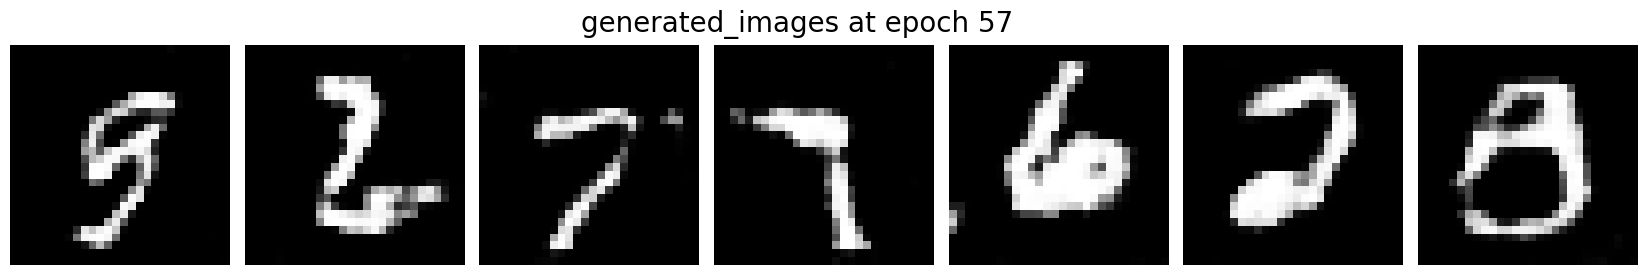

Epoch 58/60: : 100%|██████████| 938/938 [00:30<00:00, 30.48it/s, generator_loss=2.74, discriminator_loss=0.356, D(x)=0.781, D(G(z1))=0.0409, D(G(z2))=0.116]


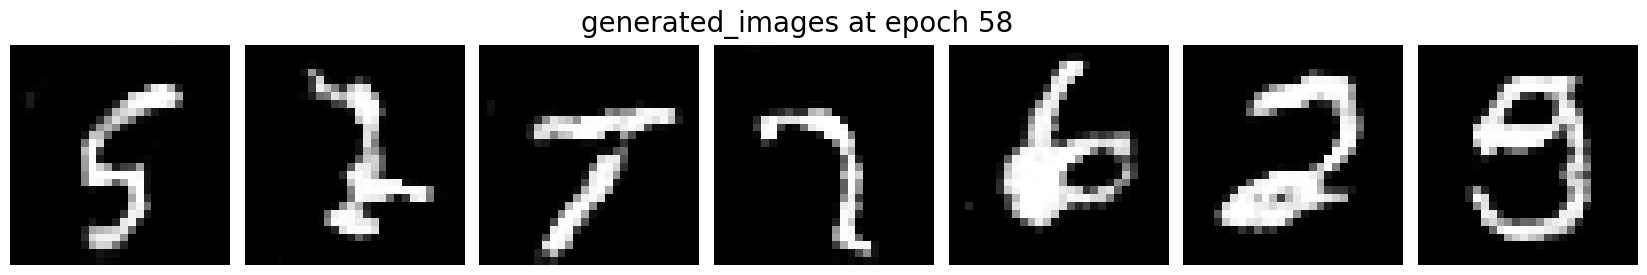

Epoch 59/60: : 100%|██████████| 938/938 [00:29<00:00, 31.52it/s, generator_loss=3.27, discriminator_loss=0.249, D(x)=0.829, D(G(z1))=0.0153, D(G(z2))=0.0759]


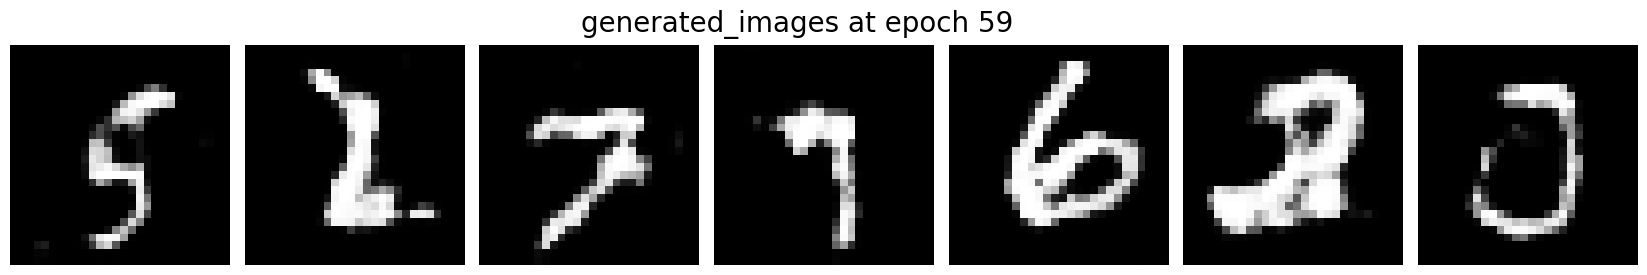

Epoch 60/60: : 100%|██████████| 938/938 [00:30<00:00, 31.21it/s, generator_loss=3.97, discriminator_loss=0.131, D(x)=0.953, D(G(z1))=0.0718, D(G(z2))=0.0316]


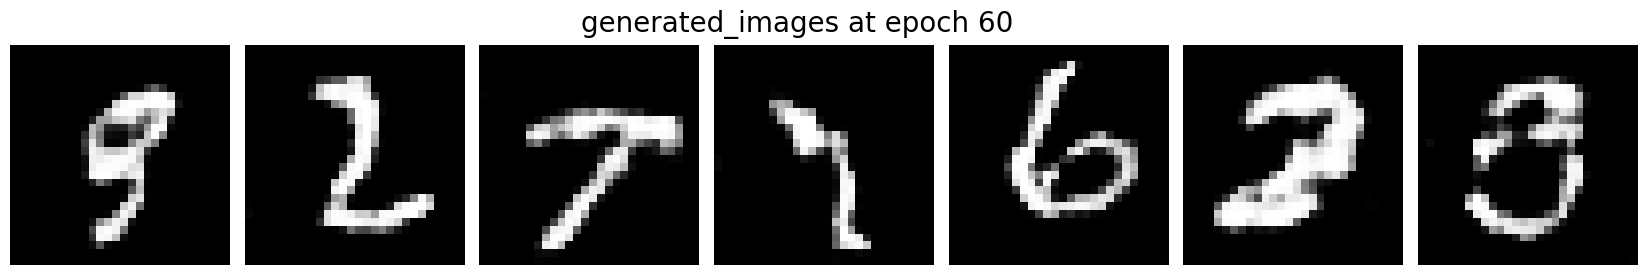

In [13]:
sample_noise = torch.randn(7, Z).to(device)

# Training loop
for i in range(1,EPOCHS+1):
  pbar = tqdm(train_dataloader)
  for b, data in enumerate(pbar):
    # Every data instance is an input + label pair. We don't need the label
    inputs, _ = data
    inputs = inputs.to(device)
    inputs = (inputs - 0.5) * 2 # setting data range to [-1,1]

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################

    ## Train with all-real batch
    discriminator.zero_grad()
    # Set up labels
    label = torch.full((inputs.shape[0],1), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = discriminator(inputs)
    # Calculate loss on all-real batch
    errD_real = loss_fn(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(inputs.shape[0], Z, device=device)
    # Generate fake image batch with G
    fake = generator(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = discriminator(fake.detach())
    # Calculate D's loss on the all-fake batch
    errD_fake = loss_fn(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizer_disc.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    generator.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = discriminator(fake)
    # Calculate G's loss based on this output
    errG = loss_fn(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizer_gen.step()

    pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
    pbar.set_postfix({"generator_loss": errG.item(), "discriminator_loss": errD.item(), "D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2})

  with torch.no_grad():
    generations = generator(sample_noise).cpu()
    generations = (generations + 1) / 2 # setting generations range to [0,1]
  display_image_grid(generations.squeeze(1), 1, 7, f"generated_images at epoch {i}")


In [14]:
# Set the generator to eval state
generator.eval()

Generator(
  (gen_model): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Reshape()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))

### Generation through GANs

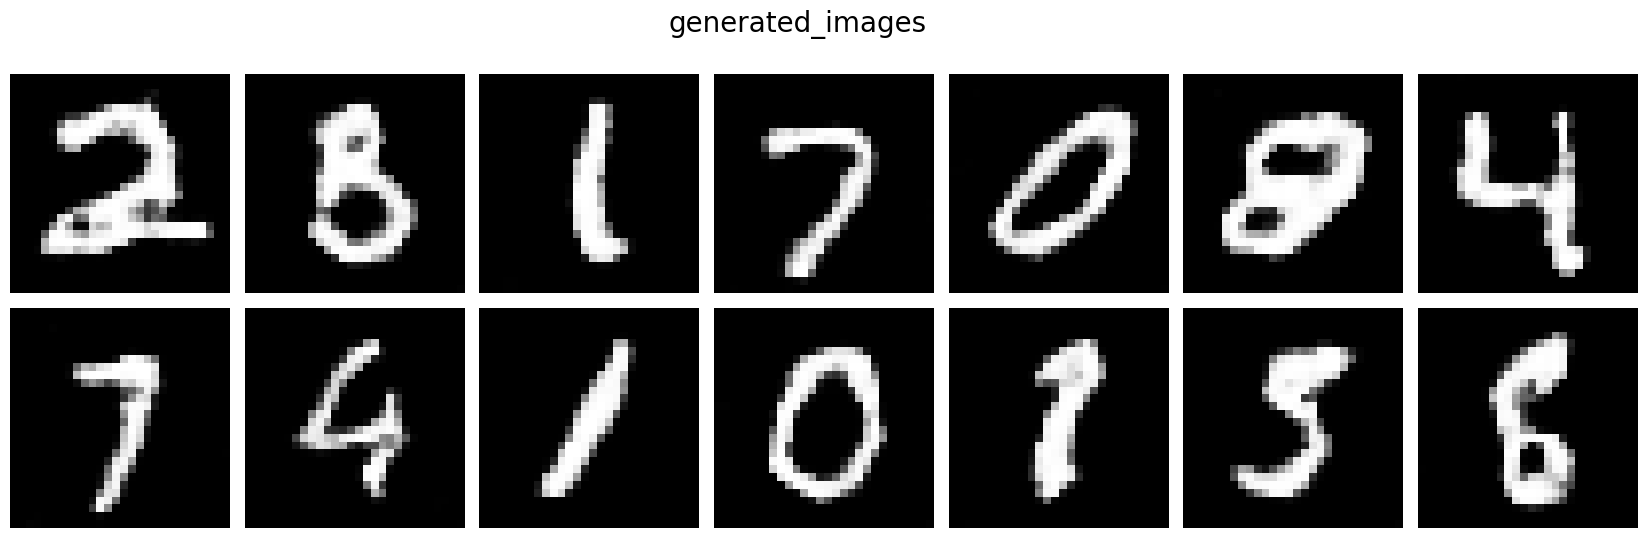

In [15]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder

rows, cols = 2, 7
sample_noise = torch.randn(rows*cols, Z).to(device)
with torch.no_grad():
  generations = generator(sample_noise).cpu()
  generations = (generations + 1) / 2 # setting generations range to [0,1]
display_image_grid(generations.squeeze(1), rows, cols, "generated_images")

### Discussion

As we can see, the generator produces very nice and beliveable images. It was also able to circumvent the blurriness issue present in VAEs. However, GANs are notoriously unstable during training and hard to train. This a relatively small data so that wasn't much of an issue here. Another issue with GANs is that they may start generating only one type of images. To resolve this, conditional GANs were introduced where in addition to noise, a condition(label) is also passed to generator.